<p align="center">
  <img src="images\Hub_title.png" alt="[YOUR_IMAGE_ALT]">
</p>

## **Business Understanding**

### **Overview**
Tourism is a thriving industry in Kenya, and travelers often face the challenge of choosing the right destinations for their trips. Our project aims to address this problem by creating a recommendation system that assists users in discovering personalized tourist destinations in the country.

### **Problem Statement**

Travelers often struggle to choose the most suitable tourist destinations for their trips. With an overwhelming number of options available, personalized recommendations are crucial. Our project aims to address this challenge by creating a recommendation system that suggests relevant destinations in Kenya based on user preferences and historical interactions.

#### **Stakeholders**
1. **Travelers**: They seek relevant recommendations based on their preferences, interests, and historical interactions.
2. **Tourism Agencies**: These organizations can enhance user experiences by providing tailored suggestions.
3. **Local Businesses**: Recommendations can drive footfall to local attractions, restaurants, and accommodations.

### **Objectives**:

- "Build a collaborative filtering model to recommend destinations."
- "Reduce cold-start problem by incorporating content-based features."
- "Model Recall score ≥ 80%"
- "Model Accuracy ≥ 80%"

### **Proposed Solution and Metrics of Success**
We propose building a hybrid recommendation system that combines collaborative filtering and content-based approaches. Success metrics include accuracy, recall and precision scores.

### **Challenges**

1. **Data Quality and Diversity**:
   - Presence of missing values, outliers, or inaccuracies.
   - Ensuring diverse and representative data across different types of destinations (e.g., cities, beaches, historical sites) is essential.

2. **Cold-Start Problem**:
   - New users with limited interaction history pose a challenge. How do we recommend destinations for them?
   - Balancing collaborative filtering (based on user behavior) with content-based filtering (based on destination features) is critical.

3. **Scalability and Real-Time Recommendations**:
   - As the user base grows, the system must handle increased computational demands.
   - Providing real-time recommendations during user interactions requires efficient algorithms.

4. **User Engagement and Interpretability**:
   - Recommendations should align with user interests to keep them engaged.
   - Ensuring transparency and interpretability of the recommendation process is important.

### **Conclusion**
Our project has significant implications for travelers, tourism agencies, and local businesses. By solving this problem, we contribute to enhancing travel experiences and promoting local economies.


## ***Data Understanding***

### *Data Sources and Relevance*
- The dataset was scraped using the **APIFY Tripadvisor Scraper**.
- It contains information about tourist destinations, including their names, categories, ratings, review counts, images, and other relevant features.
- The data's relevance lies in its ability to help us recommend destinations to travelers based on their preferences and historical interactions.

### *Dataset Overview*
- The dataset consists of **2567 entries** (rows).
- Key columns include:
  - **Name**: The name of the destination.
  - **Category**: The type of destination (e.g., city, beach, historical site).
  - **Rating**: The average user rating (ranging from 1.0 to 5.0).
  - **Number of Reviews**: The count of user reviews.
  - **Image**: URLs to images representing the destinations.
  - **Photo Count**: The number of photos associated with each destination.
  - **Price Range**: Information about the cost level (if available).
  - **Review Tags**: Descriptive tags associated with reviews.
  - **Photos**: Additional photo URLs.
  - **Price Level**: Indication of price range (if available).

### *Justification for Feature Inclusion*
- **Name**, **Category**, and **Rating**: Essential for personalized recommendations.
- **Number of Reviews**: Reflects popularity and user engagement.
- **Image** and **Photo Count**: Enhance user experience.
- **Price Range** and **Price Level**: Useful for budget-conscious travelers.
- **Review Tags**: Provides insights into user preferences.

### *Data Limitations*
- **Missing Values**: Some entries lack ratings, images, or price information.
- **Limited Price Data**: Only 1487 entries have price-related details.
- **Data Quality**: Ensure data quality and handle missing values appropriately.

## ***Data Preparation***

In [1]:
# Importing necessary libraries
import pandas as pd
import json
import glob
import re
import string



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans


from surprise import Dataset, Reader, KNNBasic, SVD, NMF, KNNWithMeans, SVDpp
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.model_selection import cross_validate


import warnings
# Ignore future deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style('darkgrid')


class DataCleaning:
    def __init__(self):
        pass

    def read_json_files(self, json_files, expected_columns):
    # Reads multiple JSON files and concatenates them into a single DataFrame
        dfs = []
        for file in json_files:
            with open(file, encoding='utf-8', errors='ignore') as f:
                json_data = json.load(f)
                df = pd.DataFrame([
                        {
                            col: item.get(col, np.nan) for col in expected_columns
                        }
                        for item in json_data                 
                
                    
                ])
                dfs.append(df)
                self.df = pd.concat(dfs, ignore_index=True)
                
        return self.df
    
   
    def drop_columns(self, columns, df):
        # Drops specified columns from the DataFrame
        self.df.drop(columns=columns, inplace=True)
        
    def missing_values_percentage(self, df):
        # Calculates the percentage of missing values in each column
        column_percentages = self.df.isnull().sum() / len(self.df) * 100
        columns_with_missing_values = column_percentages[column_percentages > 0]
        return columns_with_missing_values.sort_values(ascending=False) 
    
    def drop_above_threshold(self, threshold):
        # Drops columns with missing values percentage above the specified threshold
        column_percentages = self.missing_values_percentage(self.df)
        columns_with_missing_values = column_percentages[column_percentages > threshold]
        columns_to_drop = columns_with_missing_values.index.tolist()
        self.df.drop(columns=columns_to_drop, inplace=True)
        
    def split_price_range(self):
        # Splits the priceRange column into LowerPrice and UpperPrice columns
        self.df[['LowerPrice', 'UpperPrice']] = self.df['priceRange'].str.replace('KES', '').str.split(' - ', expand=True)
        self.df['LowerPrice'] = self.df['LowerPrice'].str.replace(',', '').astype(float)
        self.df['UpperPrice'] = self.df['UpperPrice'].str.replace(',', '').astype(float)

    def fill_missing_prices(self):
        # Fills missing values in LowerPrice and UpperPrice columns based on type (ATTRACTION or HOTEL)
        self.df.loc[self.df['type'] == 'ATTRACTION', 'LowerPrice'] = self.df.loc[self.df['type'] == 'ATTRACTION', 'LowerPrice'].fillna(self.df['LowerPrice'].min())
        self.df.loc[self.df['type'] == 'ATTRACTION', 'UpperPrice'] = self.df.loc[self.df['type'] == 'ATTRACTION', 'UpperPrice'].fillna(self.df['UpperPrice'].min())
        self.df.loc[self.df['type'] == 'HOTEL', 'LowerPrice'] = self.df.loc[self.df['type'] == 'HOTEL', 'LowerPrice'].fillna(self.df['LowerPrice'].mean())
        self.df.loc[self.df['type'] == 'HOTEL', 'UpperPrice'] = self.df.loc[self.df['type'] == 'HOTEL', 'UpperPrice'].fillna(self.df['UpperPrice'].mean())


    def clean_ratings(self):
        # Replaces missing values in the rating column with 0
        self.df['rating'].fillna(5, inplace=True)

    def clean_review_tags(self):
        # Cleans up the reviewTags column by extracting the text values
        self.df.loc[:, 'reviewTags'] = self.df['reviewTags'].apply(lambda entries: [{'text': entry['text']} for entry in entries] if isinstance(entries, list) else [])
        self.df.loc[:, 'reviewTags'] = self.df['reviewTags'].apply(lambda tags: [tag['text'] for tag in tags])


    def drop_missing_values(self, columns):
        # Drops rows with missing values in specified columns
        self.df = self.df.dropna(subset=columns)

    def drop_unused_columns(self, columns):
        # Drops unused columns from the DataFrame
        self.df = self.df.drop(columns=columns)

    def drop_rows_with_nan(self):
        # Drops rows with NaN values
        self.df = self.df.dropna()

    def save_to_csv(self, file_path):
        # Saves the DataFrame to a CSV file
        self.df.to_csv(file_path, index=False)





### ***Data Cleaning***

In [2]:
# Importing necessary libraries
import pandas as pd
import json
import glob
import re
import string



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report


import joblib


# Filter warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')




class DataSourcing:
    def __init__(self):
        self.df = None

    def read_json_files(self, json_files, expected_columns):
    # Reads multiple JSON files and concatenates them into a single DataFrame
        dfs = []
        for file in json_files:
            with open(file, encoding='utf-8', errors='ignore') as f:
                json_data = json.load(f)
                df = pd.DataFrame([
                        {
                            col: item.get(col, np.nan) for col in expected_columns
                        }
                        for item in json_data                 
                
                    
                ])
                dfs.append(df)
                self.df = pd.concat(dfs, ignore_index=True)
                
        return self.df
    
    def dataframe_details(self,df):
        """
        Print details of the dataframe.
        Parameters:
        df (DataFrame): The dataframe to be analyzed.
        Returns:
        None
        """
        print("============================")
        print(f"DATAFRAME SHAPE: {df.shape}")
        print("============================\n\n")
        print("================")
        print(f"DATAFRAME HEAD:")
        print("================")
        print(f"{df.head()}")
        print("========================================================================\n\n")
        print("=======================")
        print(f"DATAFRAME COLUMNS INFO:")
        print("=======================")
        print(f"{df.info()}")
        print("========================================================================\n\n")
        print("==========================")
        print(f"DATAFRAME KEY STATISTICS:")
        print("==========================")
        print(f"{df.describe().transpose()}")
        print("========================================================================\n\n")

    

***DataFrame info***

In [3]:
ds = DataSourcing()

files = [
        "data\kenya.json", "data\Tripadvisor1.json",
        "data\Tripadvisor2.json", "data\Tripadvisor3.json", "data\Tripadvisor4.json"
        ]
expected_columns = [
        "name", "category", "rating", "numberOfReviews",
        "image", "photoCount", "priceRange", "reviewTags",
        "priceLevel", "locationString"
                    ]

data = ds.read_json_files(files, expected_columns)

In [4]:
ds.dataframe_details(data)

DATAFRAME SHAPE: (5544, 10)


DATAFRAME HEAD:
                                      name    category  rating  \
0                         Observation Hill  attraction     4.5   
1             Mount Longonot National Park  attraction     4.5   
2  Karen Blixen Coffee Garden and Cottages  attraction     4.5   
3                           Kiambethu Farm  attraction     5.0   
4                        Fort Jesus Museum  attraction     4.0   

   numberOfReviews                                              image  \
0              782  https://media-cdn.tripadvisor.com/media/photo-...   
1              208  https://media-cdn.tripadvisor.com/media/photo-...   
2              591  https://media-cdn.tripadvisor.com/media/photo-...   
3              226  https://media-cdn.tripadvisor.com/media/photo-...   
4              978  https://media-cdn.tripadvisor.com/media/photo-...   

   photoCount priceRange                                         reviewTags  \
0         423        NaN  [{'text': 'gr

***Check for Duplicates***

In [5]:
# Convert list columns to strings to avoid unhashable type errors
data['reviewTags'] = data['reviewTags'].apply(lambda x: str(x) if isinstance(x, list) else x)
# data['photos'] = data['photos'].apply(lambda x: str(x) if isinstance(x, list) else x)

# Check for duplicates
duplicates = data.duplicated()

# Display duplicates
print("Duplicate Rows:")
duplicates.value_counts()

Duplicate Rows:


False    4760
True      784
dtype: int64

*Drop Duplicates*

In [6]:
# Drop the duplicate rows
data = data.drop_duplicates()
data.drop_duplicates(subset=['name'], inplace=True)
# Display the cleaned data
print('Cleaned Data Shape:')
print(data.shape)
print('='*45)
print(data.info())

Cleaned Data Shape:
(1962, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 4543
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1962 non-null   object 
 1   category         1962 non-null   object 
 2   rating           1959 non-null   float64
 3   numberOfReviews  1962 non-null   int64  
 4   image            1959 non-null   object 
 5   photoCount       1962 non-null   int64  
 6   priceRange       1066 non-null   object 
 7   reviewTags       1962 non-null   object 
 8   priceLevel       1066 non-null   object 
 9   locationString   1445 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 168.6+ KB
None


### ***Feature Engineering***

In [7]:
class DataPreprocessing(DataSourcing):
    def __init__(self):
        super().__init__()
        """Data Preprocessing class that inherits from the data sourcing class.
        Contains functions to be used to check certain aspects in the data for cleaning.
        Checks for duplicates, nulls and outliers
        """
      

    def check_duplicates(self, data):
        duplicates = data[data.duplicated()].shape[0]
        print("There are {} duplicates in the data.".format(duplicates))
        
    def check_null_values(self, data):
        null_values = data.isnull().sum()
        print(null_values)
        print("====================================")
        print("List of columns with missing values:")
        print("====================================")
        return null_values[null_values > 0].index.tolist()



In [8]:
# Initialize the data preprocessing class
dp = DataPreprocessing()
data.columns

Index(['name', 'category', 'rating', 'numberOfReviews', 'image', 'photoCount',
       'priceRange', 'reviewTags', 'priceLevel', 'locationString'],
      dtype='object')

***1. Extract `reviews` and `texts` from `reviewTags`***

In [9]:
import ast

# Convert the string representations of lists of dictionaries to actual lists of dictionaries
data['reviewTags'] = data['reviewTags'].apply(ast.literal_eval)

# Extract texts and reviews from the reviewTags column
data['texts'] = data['reviewTags'].apply(lambda x: [d['text'] for d in x])
data['reviews'] = data['reviewTags'].apply(lambda x: [d['reviews'] for d in x])

# Display the updated DataFrame
data.head(2)

,name,category,rating,numberOfReviews,image,photoCount,priceRange,reviewTags,priceLevel,locationString,texts,reviews
0,Observation Hill,attraction,4.5,782,https://media-cdn.tripadvisor.com/media/photo-...,423,NaN,"[{'text': 'great view', 'reviews': 55}, {'text...",NaN,"Amboseli National Park, Amboseli Eco-system, R...","[great view, vantage point, entire park, short...","[55, 17, 16, 15, 11, 8, 89, 141, 137, 81, 98, ..."
1,Mount Longonot National Park,attraction,4.5,208,https://media-cdn.tripadvisor.com/media/photo-...,441,NaN,"[{'text': 'crater rim', 'reviews': 18}, {'text...",NaN,"Maai Mahiu, Rift Valley Province","[crater rim, day trip, start early, amazing vi...","[18, 14, 10, 8, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, ..."


***2. Decode the `priceLevel` column***

In [10]:
data['priceLevel'].value_counts()

$       443
$$      292
$$$$    213
$$$     118
Name: priceLevel, dtype: int64

*Map the `$` into their corresponding categories*

1. **Luxury**: The most expensive category, offering premium services and facilities.

2. **Premium**: Mid-range in price, providing high-quality services and accommodations.

3. **Standard**: Affordable options with good services and facilities.

4. **Budget**: The most economical choice, offering basic services and accommodations.

In [11]:
# Mapping function
def map_dollar_signs(dollar_signs):
    mapping = {
        "$$$$": "Luxury",
        "$$$": "Premium",
        "$$": "Standard",
        "$": "Budget"
    }
    return mapping.get(dollar_signs, "Unknown")

# Create new column 'priceLevel'
data['priceLevel'] = data['priceLevel'].apply(map_dollar_signs)

# Display the DataFrame
data['priceLevel'].value_counts()

Unknown     896
Budget      443
Standard    292
Luxury      213
Premium     118
Name: priceLevel, dtype: int64

***3. Create new price columns (`upperPrice` & `lowerPrice`)***

In [12]:
def split_price_range(data, conversion_rate=145.0):
    # Extract unique values from the priceRange column
    unique_price_ranges = data['priceRange'].nunique()

    # Print the number of unique values (optional)
    print(f"Number of unique price ranges: {unique_price_ranges}")

    # Convert USD prices to KES and extract lowerPrice and upperPrice
    def convert_and_extract(x):
        if isinstance(x, str):
            if '$' in x:
                lower_price = float(x.split(' - ')[0].replace('$', '').replace(',', '')) * conversion_rate
                upper_price = float(x.split(' - ')[-1].replace('$', '').replace(',', '')) * conversion_rate
            elif 'KES' in x:
                lower_price = float(x.split(' - ')[0].replace('KES', '').replace(',', ''))
                upper_price = float(x.split(' - ')[-1].replace('KES', '').replace(',', ''))
            return lower_price, upper_price
        return np.nan, np.nan

    data[['lowerPrice', 'upperPrice']] = data['priceRange'].apply(
        lambda x: pd.Series(convert_and_extract(x))
    )

    # Fill missing values with NaN
    data['lowerPrice'] = data['lowerPrice'].fillna(np.nan)
    data['upperPrice'] = data['upperPrice'].fillna(np.nan)

    return data[['lowerPrice', 'upperPrice']].tail()


In [13]:
split_price_range(data)


Number of unique price ranges: 1025


,lowerPrice,upperPrice
4539,NaN,NaN
4540,3374.0,3374.0
4541,NaN,NaN
4542,7008.0,9603.0
4543,2206.0,3763.0


In [14]:
data[['upperPrice', 'lowerPrice']].nunique()

upperPrice    564
lowerPrice    511
dtype: int64

In [15]:
data[['upperPrice', 'lowerPrice']].value_counts().head()

upperPrice  lowerPrice
28129.0     28129.0       3
15190.0     11392.0       3
4282.0      3893.0        2
5191.0      4672.0        2
10549.0     7736.0        2
dtype: int64

***4. Create new column (`weighted_sentiment`) for Sentiment Analysis of Reviews***

##### *STEPS*

    Step 1: Perform Sentiment Analysis

    - We will use TextBlob to calculate the sentiment polarity. (Polarity is a float within the range [-1.0, 1.0], where -1.0 represents a negative sentiment and 1.0 represents a positive sentiment.)

    Step 2: Weight the Sentiment Scores

    Step 3: Aggregate the Weighted Scores

  

We will create an additional column, `weighted_sentiment`, that represents the weighted average sentiment score for each place. This column can be used to make recommendations based on the overall sentiment of reviews.

In [16]:
# !pip install textblob
from textblob import TextBlob

# Perform sentiment analysis and calculate weighted sentiment scores
def calculate_weighted_sentiment(texts, reviews):
    sentiments = [TextBlob(text).sentiment.polarity for text in texts]
    weighted_sentiments = [sentiment * review for sentiment, review in zip(sentiments, reviews)]
    total_reviews = sum(reviews)
    weighted_average_sentiment = sum(weighted_sentiments) / total_reviews if total_reviews > 0 else 0
    return weighted_average_sentiment

# The statistical method below helps in balancing the sentiment score with the number of reviews, preventing
# entities with few reviews from ranking disproportionately high or low.
def bayesian_average(sentiment, num_reviews, C=10, m=0.03):
    """
    sentiment: Weighted sentiment score
    num_reviews: Number of reviews
    C: Weight parameter (the number of reviews we deem sufficient for confidence)
    m: Prior mean sentiment (average sentiment across all entities)
    """
    return (C * m + sentiment * num_reviews) / (C + num_reviews)

data['weighted_sentiment'] = data.apply(lambda row: calculate_weighted_sentiment(row['texts'], row['reviews']), axis=1)

data['adjusted_sentiment'] = data.apply(
    lambda row: bayesian_average(
        row['weighted_sentiment'], 
        row['numberOfReviews'], 
        C=10, 
        m=data['weighted_sentiment'].mean()
    ), 
    axis=1
)


# Display the updated DataFrame
review_data = data[['name','texts','reviews', 'numberOfReviews', 'weighted_sentiment', 'adjusted_sentiment']]

review_data.head()

,name,texts,reviews,numberOfReviews,weighted_sentiment,adjusted_sentiment
0,Observation Hill,"[great view, vantage point, entire park, short...","[55, 17, 16, 15, 11, 8, 89, 141, 137, 81, 98, ...",782,0.039423,0.039152
1,Mount Longonot National Park,"[crater rim, day trip, start early, amazing vi...","[18, 14, 10, 8, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, ...",208,0.038617,0.037670
2,Karen Blixen Coffee Garden and Cottages,"[movie, africa, giraffes, safari]","[42, 94, 10, 14]",591,0.000000,0.000299
3,Kiambethu Farm,"[indigenous forest, tea plantation, delicious ...","[22, 27, 16, 14, 6, 6, 5, 4, 4, 3, 3, 5, 64, 2...",226,0.050552,0.049171
4,Fort Jesus Museum,"[old town, interesting history, slave trade, t...","[132, 17, 17, 46, 28, 9, 14, 14, 121, 28, 36, ...",978,0.047081,0.046786


In [17]:
data['reviews'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1962 entries, 0 to 4543
Series name: reviews
Non-Null Count  Dtype 
--------------  ----- 
1962 non-null   object
dtypes: object(1)
memory usage: 30.7+ KB


***5. Extract the `location` & `province` from `locationString`***

In [18]:
# Replace empty strings or null-like values with np.nan
data['locationString'] = data['locationString'].apply(lambda x: np.nan if pd.isnull(x) or x.strip() == '' else x)

# Fill remaining null values with a placeholder (e.g., "Unknown, Unknown")
# data['locationString'] = data['locationString'].fillna('Unknown, Unknown')

# Extract the location (before the first comma)
data['location'] = data['locationString'].str.split(',', n=1).str[0].str.strip()

# Extract the province (after the last comma)
data['province'] = data['locationString'].str.split(',').str[-1].str.strip()

# Display the DataFrame with the new columns
print(data[['location', 'province']].head())


                 location              province
0  Amboseli National Park  Rift Valley Province
1              Maai Mahiu  Rift Valley Province
2                 Nairobi               Nairobi
3                  Limuru      Central Province
4                 Mombasa        Coast Province


***6. Create a new value `tour operator` in the `category column`***

There are tour operators categorized as attractions. Let's separate them into their own category for better classification.

In [19]:
# Keywords to search for
keywords = ['safari', 'safaris', 'tour', 'tours', 'adventure',
            'adventures', 'expeditions', 'expedition', 'travels',
            'travel', 'travellers', 'escursioni']
hotel_keywords = ['cottages', 'spa', 'lodge', 'camp', 'club', 'hotel', 'resort']

# Function to update category with priority for hotel-related words
def update_category(row):
    name, current_category = row
    name_lower = name.lower()

    # Check for hotel-related keywords first
    if any(hotel_keyword in name_lower for hotel_keyword in hotel_keywords):
        return 'hotel'
    
    # Check for other keywords
    if any(keyword in name_lower for keyword in keywords):
        return 'tour operator'
    
    return current_category

# Apply the function to update the 'category' column
data['category'] = data[['name', 'category']].apply(update_category, axis=1)

# Display the updated DataFrame
data['category'].value_counts()

hotel            1404
tour operator     391
attraction        167
Name: category, dtype: int64

## ***EDA***

***Visual of the Destinations***

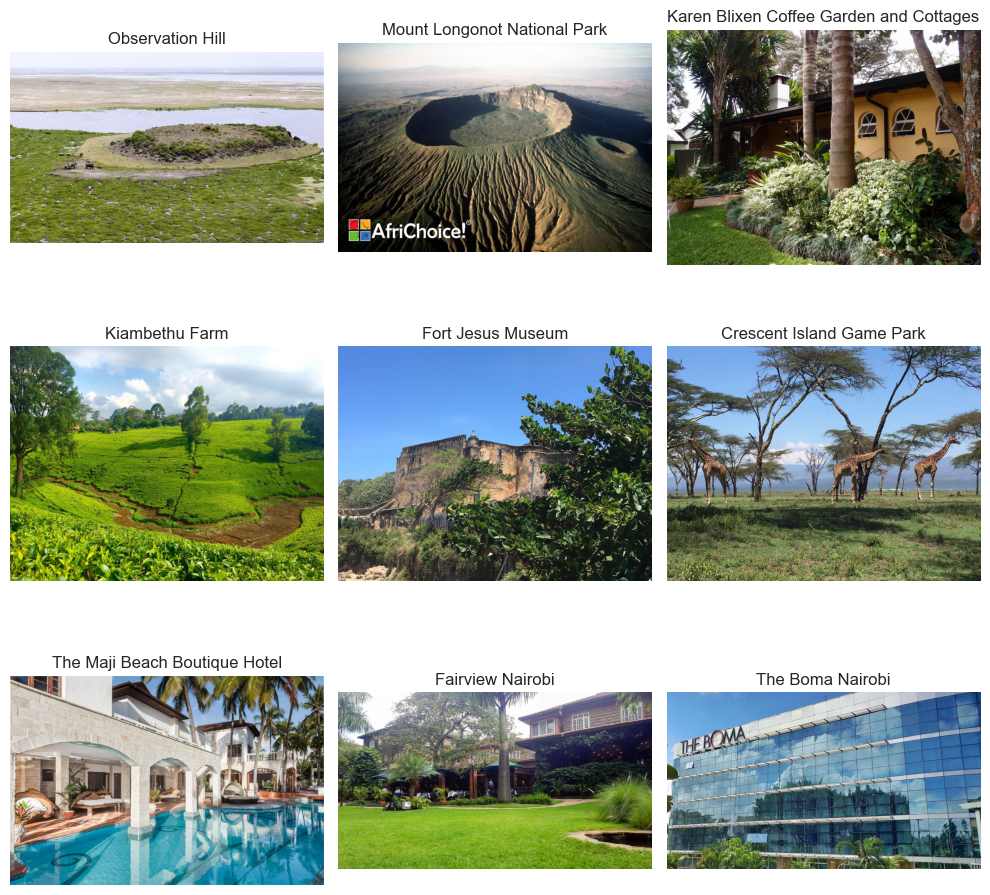

In [20]:
import requests
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Extract image URLs
# Load the first 9 images
image_urls = data['image'].tolist()
images = []

# Download images from URLs
for url in image_urls[0:9]:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(io.BytesIO(response.content))
            images.append(img)
        else:
            images.append(None)  # Append None if the image couldn't be retrieved
    except Exception as e:
        print(f"Error fetching image from {url}: {e}")
        images.append(None)

# Create a 3x3 grid of images
num_rows, num_cols = 3, 3
image_matrix = [[None for _ in range(num_cols)] for _ in range(num_rows)]

for idx, img in enumerate(images):
    row, col = divmod(idx, num_cols)
    if row < num_rows:
        image_matrix[row][col] = img

# Plot the images with labels
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i in range(num_rows):
    for j in range(num_cols):
        if image_matrix[i][j] is not None:
            axs[i, j].imshow(image_matrix[i][j])
            axs[i, j].set_title(data.loc[i * num_cols + j, 'name'])
        axs[i, j].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

***Review Bigrams Visual***

A visualization of the most common bigrams in the reviews, weighted by the number of reviews, can be useful for the tour recommendation system to find the most popular words used in the reviews.

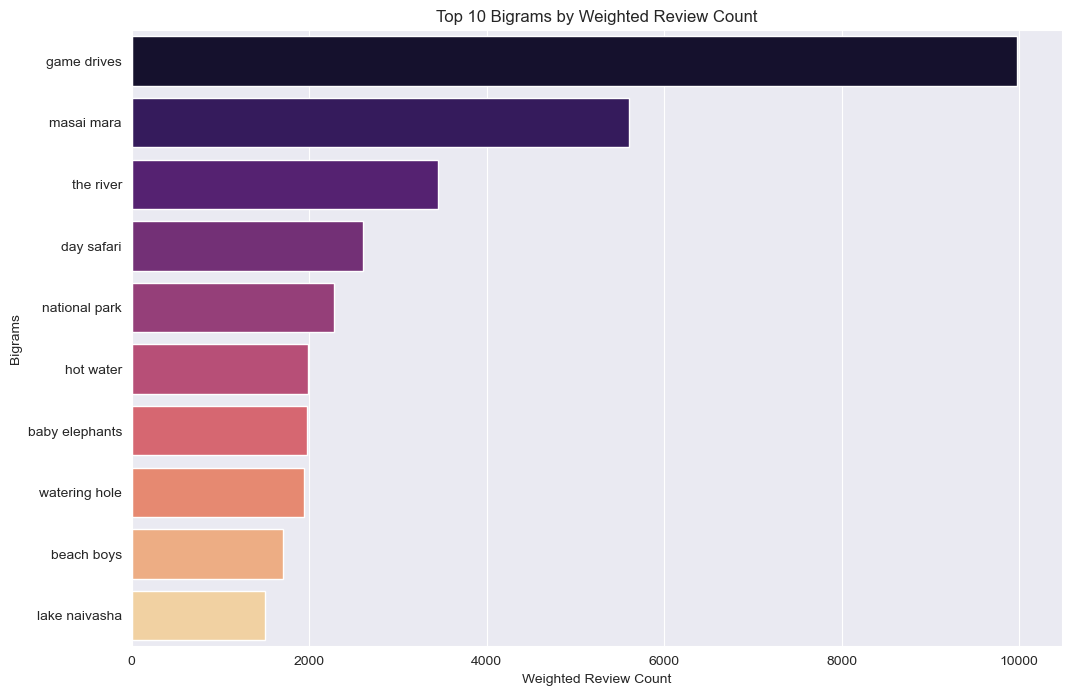

In [21]:
# Tokenize texts into bigrams and count frequencies
import nltk
from nltk.util import bigrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Tokenize texts into bigrams and count frequencies
def get_bigrams(texts, reviews):
    bigram_counts = Counter()
    for text, review in zip(texts, reviews):
        tokens = nltk.word_tokenize(text)
        bigrams_list = list(bigrams(tokens))
        for bigram in bigrams_list:
            bigram_counts[bigram] += review
    return bigram_counts

data['bigram_counts'] = data.apply(lambda row: get_bigrams(row['texts'], row['reviews']), axis=1)

# Flatten the bigrams into a single string for vectorization
def flatten_bigrams(bigram_counts):
    flattened_text = []
    for bigram, count in bigram_counts.items():
        flattened_text.extend([' '.join(bigram)] * count)
    return ' '.join(flattened_text)

data['flattened_bigrams'] = data['bigram_counts'].apply(flatten_bigrams)

# Aggregate bigram counts across all rows
total_bigram_counts = Counter()
for counts in data['bigram_counts']:
    total_bigram_counts.update(counts)

# Get the most common bigrams
most_common_bigrams = total_bigram_counts.most_common(10)
bigram_labels, bigram_values = zip(*most_common_bigrams)

# Convert tuples to strings for labels
bigram_labels = [' '.join(bigram) for bigram in bigram_labels]

# Create DataFrame for plotting
plot_data = pd.DataFrame({'Bigram': bigram_labels, 'Count': bigram_values})

# Visualize the word counts
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Bigram', data=plot_data, palette='magma')
plt.xlabel('Weighted Review Count')
plt.ylabel('Bigrams')
plt.title('Top 10 Bigrams by Weighted Review Count')
plt.show()

*Extract the main bigram that describes the destinations*

In [22]:
# Function to extract the bigram with the highest frequency
def extract_main_bigram(counter):
    if not counter:  # Check if the Counter is empty
        return None
    return max(counter, key=counter.get)

# Apply the function to create the new column
data['main_bigram'] = data['bigram_counts'].apply(extract_main_bigram)

In [23]:
# Limit the bigram counts further
top_n = 50  # Further reduce the number of bigrams
limited_bigram_frequencies = dict(total_bigram_counts.most_common(top_n))
print(f"Number of bigrams: {len(limited_bigram_frequencies)}")
print(f"Memory usage: {sum([len(str(k)) + len(str(v)) for k, v in limited_bigram_frequencies.items()]) / (1024 * 1024):.2f} MB")
import gc

# Clear variables
del total_bigram_counts
gc.collect()


Number of bigrams: 50
Memory usage: 0.00 MB


4078

***Word Cloud Visual***

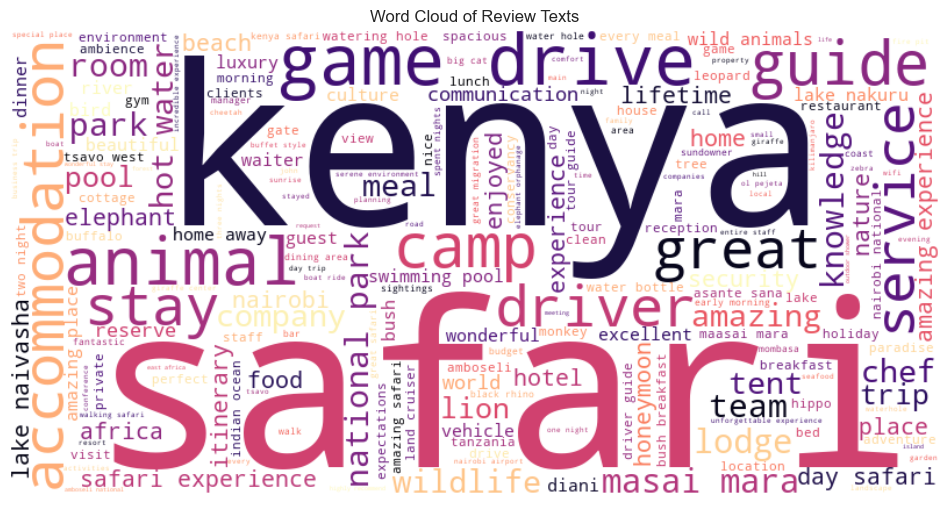

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all texts into a single string
combined_texts = ' '.join(' '.join(texts) for texts in data['texts'])

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(combined_texts)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Texts')
plt.show()


### Summary of Key Themes

- **Safari and Wildlife:** The dominant theme is wildlife experiences, highlighted by terms like "safari," "wildlife," "animals," "game drive," and specific animals such as lion, elephant, and giraffe. This suggests a strong emphasis on safari and wildlife activities.

- **Accommodation and Service:** Key terms include "lodge," "camp," "hotel," "service," and "staff," reflecting a focus on guest accommodation and overall service quality.

- **Location:** Geographic terms such as "Masai Mara," "Lake Naivasha," "Kenya," and "Nairobi" underscore the regional focus of the reviews.

- **Positive Sentiment:** Words like "amazing," "great," "beautiful," and "wonderful" point to an overall positive sentiment towards the reviewed experiences.

### Overall Sentiment

- **Positive Sentiment:** Words like "amazing," "great," "beautiful," and "enjoyable" are prevalent across multiple word clouds, suggesting overall positive sentiment towards the locations.
- **Nature and Wildlife:** Words associated with nature, wildlife, and outdoor activities (e.g., "park," "safari," "wildlife," "forest") are prominent, indicating a strong focus on natural experiences.
- **Historical and Cultural Aspects:** Words like “slave,” “trade,” and “colonialism” may point to historical or cultural themes.The presence of “interesting,” “history,” and “culture” suggests educational or informative content.


### ***Univariate Analysis***

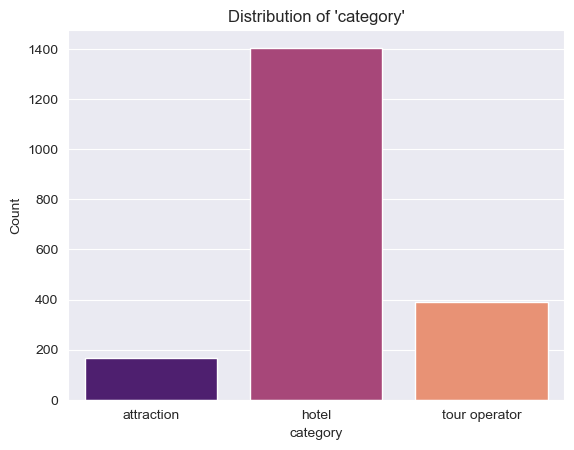

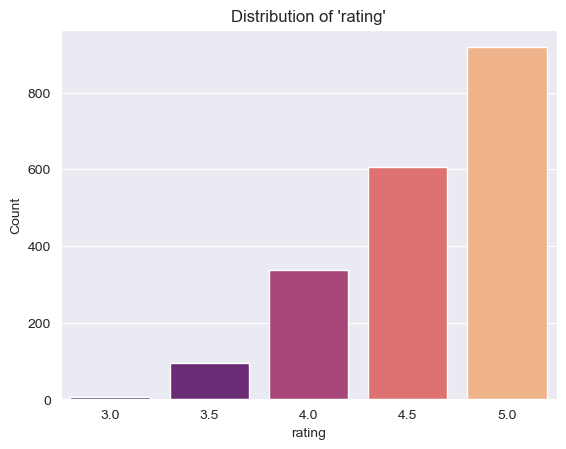

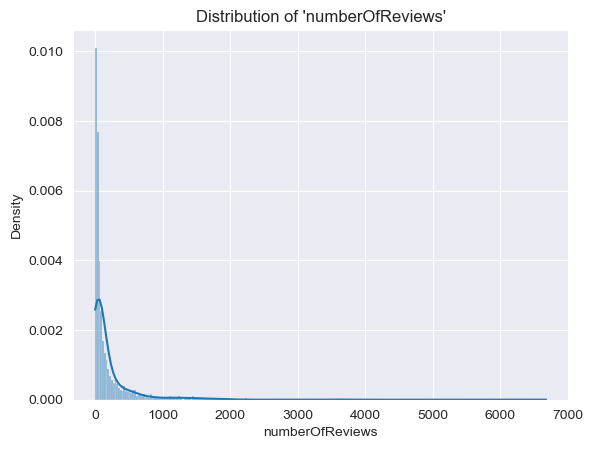

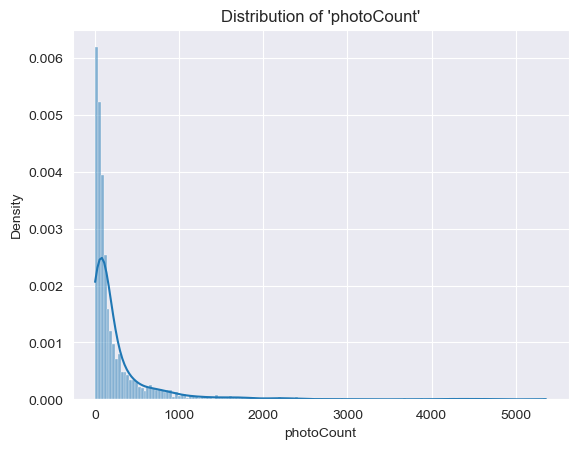

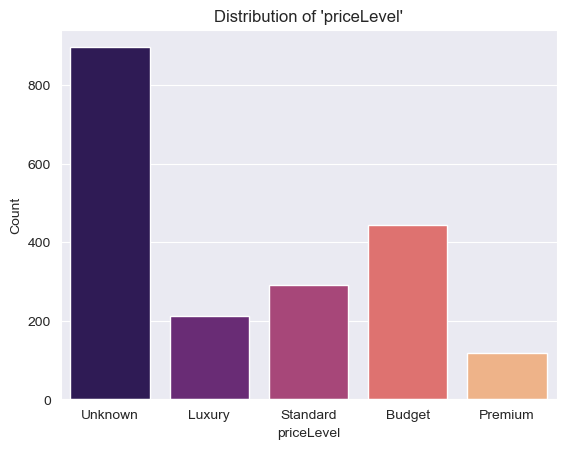

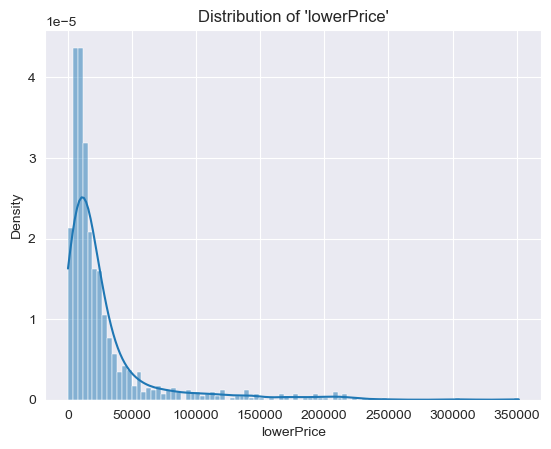

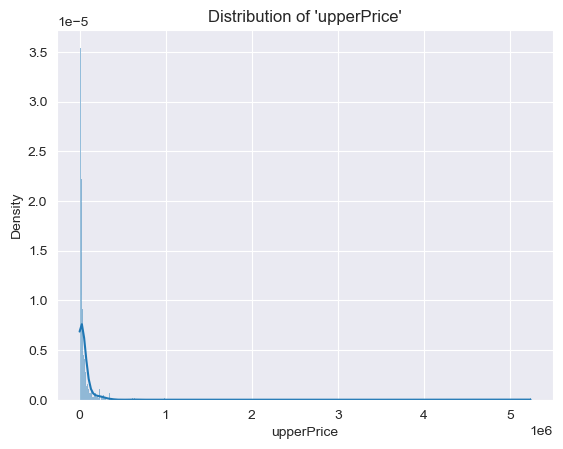

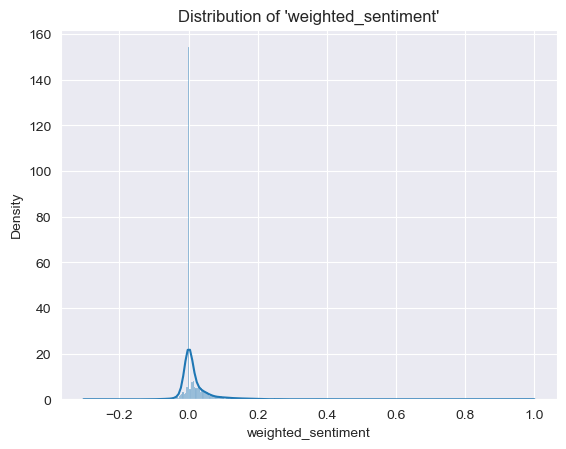

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(data, exclude_columns=[]):
    for col in data.columns:
        # Skip the column if it's in the exclude_columns list
        if col in exclude_columns:
            continue
        
        if data[col].dtype == 'object' or data[col].nunique() < 20:
            # If the column is categorical or has less than 20 unique values, use countplot
            custom_palette = 'magma'
            sns.countplot(data=data, x=col, palette=custom_palette)
            plt.title(f"Distribution of '{col}'")
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks()
            plt.show()
        elif pd.api.types.is_numeric_dtype(data[col]):
            # Plot histogram with KDE for numerical columns
            sns.histplot(data[col], kde=True, stat="density")
            plt.title(f"Distribution of '{col}'")
            plt.xlabel(col)
            plt.ylabel('Density')
            plt.show()

# Example usage
exclude = ['name', 'image', 'priceRange', 'reviewTags', 'photos', 'reviews', 'texts', 'adjusted_sentiment',
           'bigram_counts', 'main_bigram', 'location', 'province', 'locationString', 'flattened_bigrams']
plot_distribution(data, exclude_columns=exclude)


### ***Correlation Analysis***

Label encode the priceLevel so as to perform a correlation analysis.

In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['priceLevelencoded'] = label_encoder.fit_transform(data['priceLevel'])


The following columns were dropped due to being object types:
['name', 'category', 'image', 'priceRange', 'reviewTags', 'priceLevel', 'locationString', 'texts', 'reviews', 'location', 'province', 'bigram_counts', 'flattened_bigrams', 'main_bigram']


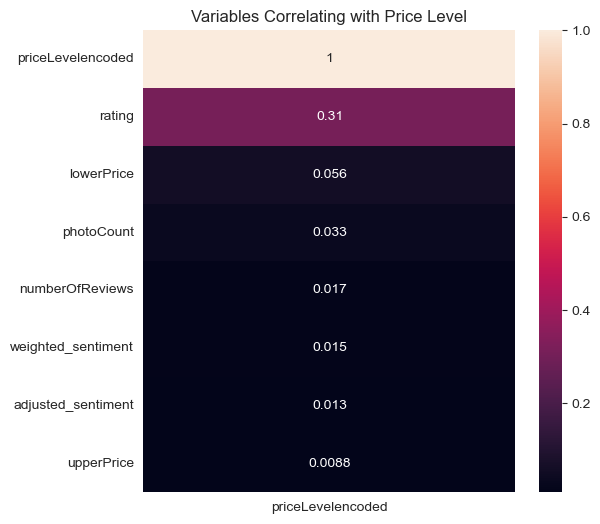

In [27]:
def correlation(df,column=None,rank=None):
    '''
    performs correlation matrix, drops non numeric object types
    variables are dataframe, column, and ranking
    ranking is optional
    column = 'column'
    rank = True for # rank 1,2,3...
    
    '''
    # Redundant check. Makes sure all columns of object type are dropped
    df_object = df.select_dtypes(include='object')
    print(f'The following columns were dropped due to being object types:\n{df_object.columns.tolist()}')
    df = df.drop(df_object,axis=1) 
    df1 = df
    if rank is True:
        try:
            df_corr = df1.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Ranked correlation to {column}')
            return(df_corr.rank(ascending=False).sort_values())
        except:
            df_corr = df1.corr()
            return(df_corr.rank(ascending=False))
    else:    
        try:
            df_corr = df.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Correlation to {column}')
            return(df_corr.sort_values(ascending=False))
        except:
            df_corr = df1.corr()
            return(df_corr)

# Getting the correlation between variables
df_corr = abs(correlation(data))
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df_corr[['priceLevelencoded']].sort_values(by='priceLevelencoded',ascending=False),annot = True)

ax.set_title('Variables Correlating with Price Level');
# plt.savefig('Group_plots/correlation_plot.png', dpi=100)

In [28]:
# Correlation matrix
correlation_matrix = data[['rating', 'numberOfReviews', 'lowerPrice', 'upperPrice', 'weighted_sentiment', 'adjusted_sentiment']].corr()
correlation_matrix


,rating,numberOfReviews,lowerPrice,upperPrice,weighted_sentiment,adjusted_sentiment
rating,1.000000,-0.066038,0.376862,0.138598,-0.053227,-0.053412
numberOfReviews,-0.066038,1.000000,0.114381,0.030369,0.003279,-0.006440
lowerPrice,0.376862,0.114381,1.000000,0.329648,-0.123438,-0.144134
upperPrice,0.138598,0.030369,0.329648,1.000000,0.071007,0.056691
weighted_sentiment,-0.053227,0.003279,-0.123438,0.071007,1.000000,0.983304
adjusted_sentiment,-0.053412,-0.006440,-0.144134,0.056691,0.983304,1.000000


### ***Top 10 Locations***

In [29]:
# Calculate the top 10 names based on average rating
top_10_names = data.groupby('name').agg({'rating': 'mean', 'category': 'first'}).nlargest(10, 'rating')

# Reset index to get 'name' as a column
top_10_names = top_10_names.reset_index()

# Display the table
print("Top 10 Names by Average Rating:")
top_10_names[['name', 'rating', 'category']]

Top 10 Names by Average Rating:


,name,rating,category
0,A Rocha Eco-Lodge & Conservation Centre,5.0,hotel
1,ACROSS WILDERNESS EXPEDITION,5.0,tour operator
2,APODIFORMES ADVENTURES,5.0,tour operator
3,Abdull Safari Kenya,5.0,tour operator
4,Absolute Vantage Limited,5.0,attraction
5,Acacia Tree Lodge,5.0,hotel
6,Ace Ecotours,5.0,tour operator
7,Ack Guest-House Machakos,5.0,hotel
8,Across The Wild Tours & Safaris,5.0,tour operator
9,Adventure 360,5.0,tour operator


### ***Bivariate Analysis***

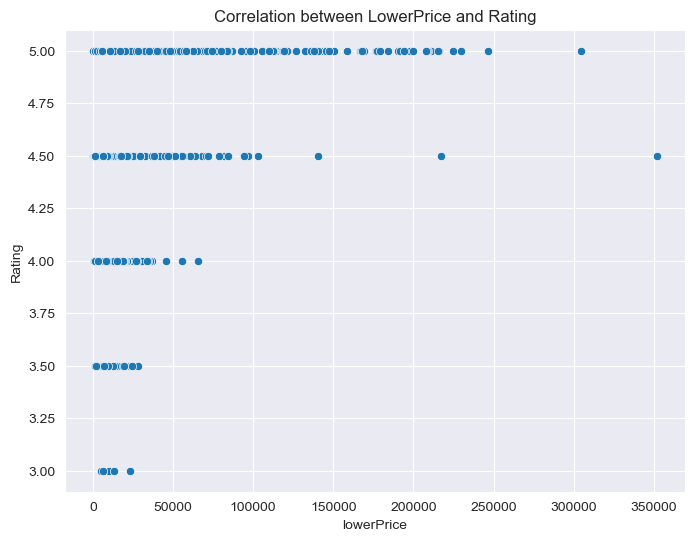

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['lowerPrice'], y=data['rating'])
plt.title('Correlation between LowerPrice and Rating')
plt.xlabel('lowerPrice')
plt.ylabel('Rating')
plt.show()

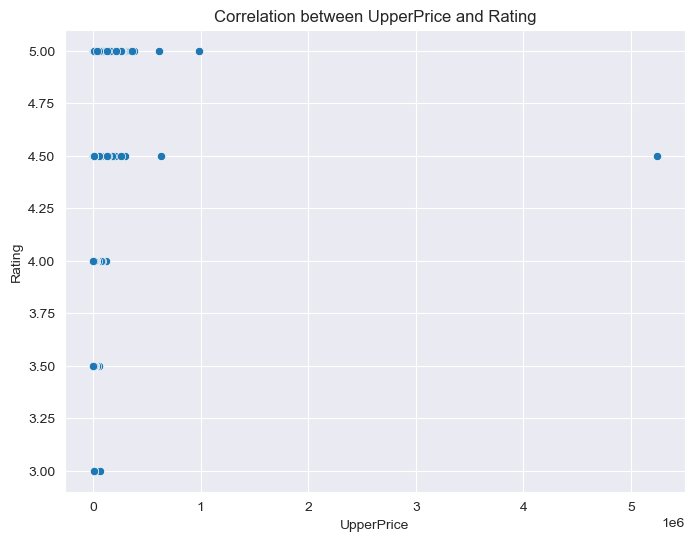

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['upperPrice'], y=data['rating'])
plt.title('Correlation between UpperPrice and Rating')
plt.xlabel('UpperPrice')
plt.ylabel('Rating')
plt.show()

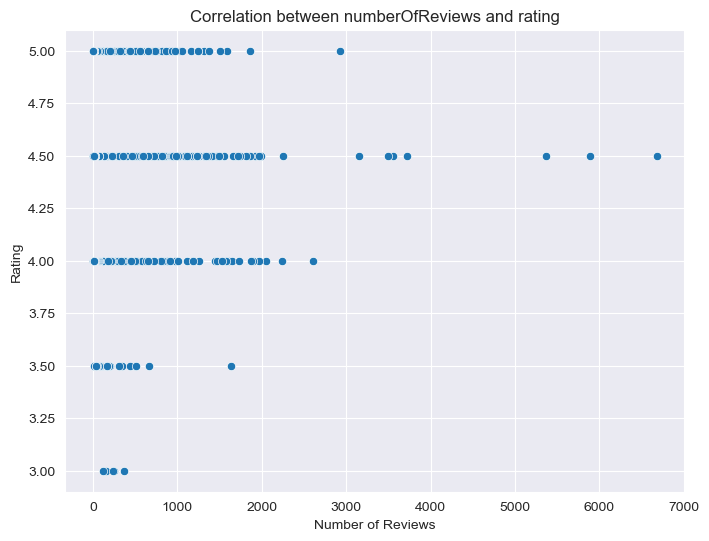

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['numberOfReviews'], y=data['rating'])
plt.title('Correlation between numberOfReviews and rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.show()

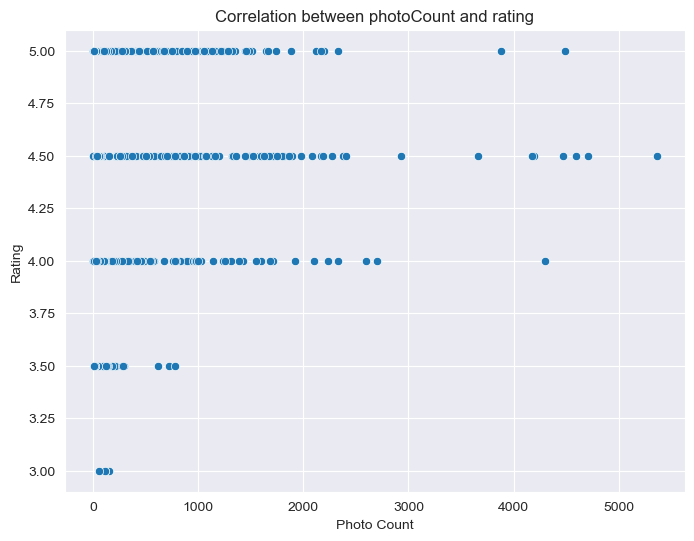

In [33]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['photoCount'], y=data['rating'])
plt.title('Correlation between photoCount and rating')
plt.xlabel('Photo Count')
plt.ylabel('Rating')
plt.show()



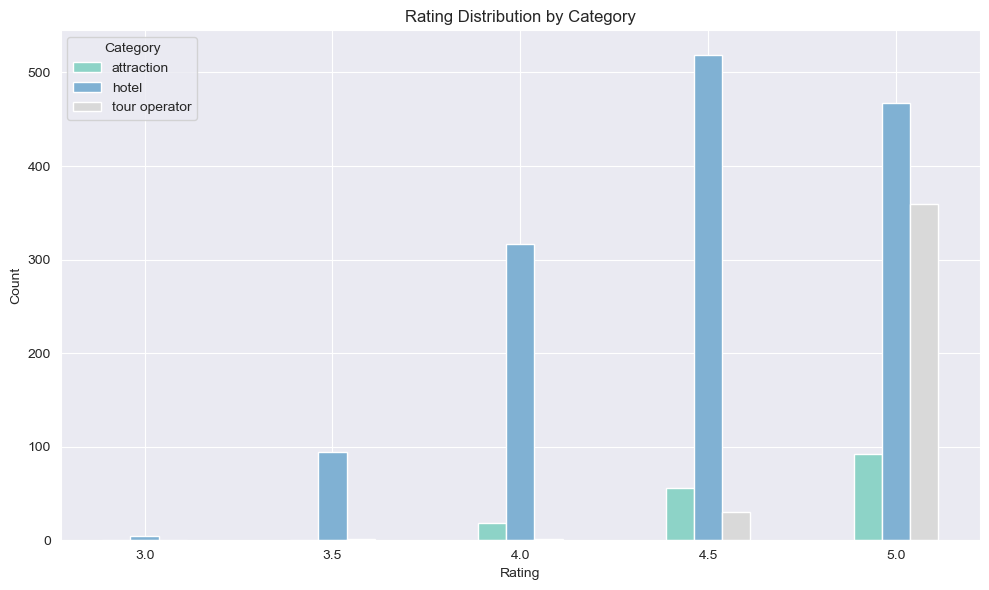

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

grouped_data = data.groupby('category')['rating'].value_counts().unstack().fillna(0)

# Get unique categories and ratings
categories = data['category'].unique()
ratings = grouped_data.columns

# Set the width of each bar
bar_width = 0.15

# Calculate the x position for each group of bars
x = np.arange(len(ratings))

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for each category within each rating
for i, category in enumerate(categories):
    ax.bar(x + (i * bar_width), grouped_data.loc[category], width=bar_width, label=category, color=plt.cm.Set3(i / len(categories)))

# Set the x-axis labels and ticks
ax.set_xticks(x + ((len(categories) - 1) * bar_width) / 2)
ax.set_xticklabels(ratings)
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Rating Distribution by Category')
ax.legend(title='Category')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


- **Higher Ratings for Attractions:** Attractions generally received higher ratings, with a larger number of ratings at 4.5 and 5.0 compared to hotels. This suggests that customers are more satisfied with attractions.

- **Bimodal Distribution for Hotels:** Hotel ratings show a bimodal distribution with peaks around 3.5 and 4.5. This indicates a split in customer experiences, with some customers being highly satisfied while others are less so.


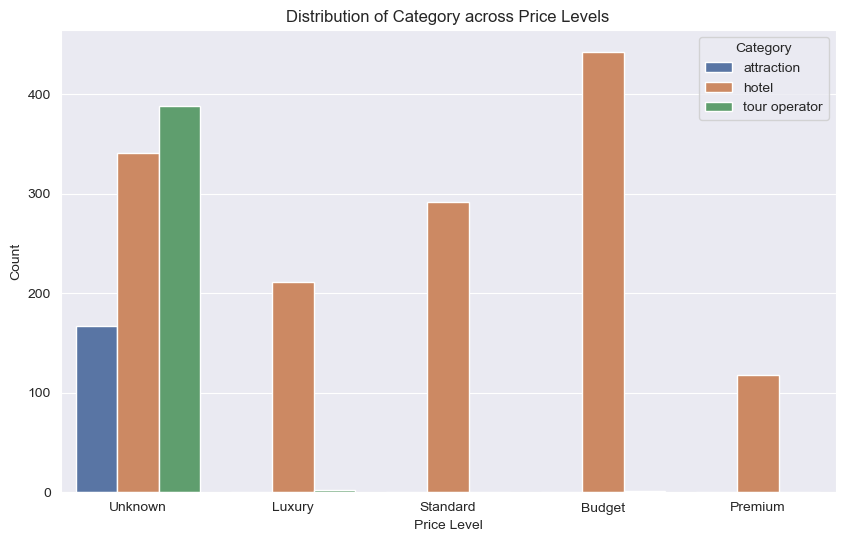

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='priceLevel', hue='category', palette='deep')
plt.title('Distribution of Category across Price Levels')
plt.xlabel('Price Level')
plt.ylabel('Count')
plt.legend(title='Category')
plt.show()

In [36]:
combined_table = data.groupby(['category', 'priceLevel']).agg(
    avg_rating=('rating', 'mean'),
    total_reviews=('numberOfReviews', 'sum'),
    avg_photo_count=('photoCount', 'mean')
).reset_index()

combined_table

,category,priceLevel,avg_rating,total_reviews,avg_photo_count
0,attraction,Unknown,4.722892,61325,399.922156
1,hotel,Budget,4.310658,39159,86.015837
2,hotel,Luxury,4.800948,74561,518.521327
3,hotel,Premium,4.483051,53793,553.347458
4,hotel,Standard,4.400344,97126,318.373288
5,hotel,Unknown,4.571848,31126,138.906158
6,tour operator,Budget,4.500000,7,7.000000
7,tour operator,Luxury,5.000000,519,364.500000
8,tour operator,Unknown,4.956186,49462,218.546392


### Summary
The attraction & tour operator categories lack price data and this presents a challenge. We will handle the issue by creating separate models for each category.

We will build 3 different recommendation models: one for each category. Since attractions & most tour operators don’t have price data, we will exclude priceLevel from the models and focus on other features like rating, reviews and sentiments.

This approach will allow tailoring SafariHub recommendation model specifically to the available data for each category.

In [37]:
# data.to_csv('C:/Users/Hp/Documents/DATA_SCIENCE/MORINGA/PHASE_5-Final_Project/SafariHub/data.csv', index=False)

# ***Modeling***

Encode the `location`, `province` and `category` columns so as to fit them into the models.

In [38]:
label_encoder = LabelEncoder()
data['location_encoded'] = label_encoder.fit_transform(data['location'])
data['province_encoded'] = label_encoder.fit_transform(data['province'])
data['category_encoded'] = label_encoder.fit_transform(data['category'])

Split the data into categories so as to work with the different requirements.
This is to avoid dropping rows that don't have price values which would be helpful for the hotel category.

In [39]:
# Filter the rows where the 'category' is 'attraction'
attraction_data = data[data['category'] == 'attraction'][[
    'name', 'category', 'rating', 'numberOfReviews', 'photoCount','category_encoded', 'location',
    'reviewTags', 'priceLevel', 'texts', 'reviews', 'weighted_sentiment', 'adjusted_sentiment',
    'bigram_counts', 'priceLevelencoded', 'location_encoded', 'province_encoded', 'flattened_bigrams'
]]

# Filter the rows where the 'category' is 'hotel'
hotel_data = data[data['category'] == 'hotel'][[
    'name', 'category', 'rating', 'numberOfReviews', 'photoCount','category_encoded',
    'priceRange', 'reviewTags', 'priceLevel', 'texts', 'reviews',
    'lowerPrice', 'upperPrice', 'weighted_sentiment', 'adjusted_sentiment',
    'bigram_counts', 'priceLevelencoded', 'location_encoded', 'province_encoded', 'flattened_bigrams'
]]

# Filter the rows where the 'category' is 'tours'
tours_data = data[data['category'] == 'tour operator'][[
    'name', 'category', 'rating', 'numberOfReviews', 'photoCount','category_encoded', 'main_bigram',
    'reviewTags', 'priceLevel', 'texts', 'reviews', 'weighted_sentiment', 'adjusted_sentiment',
    'bigram_counts', 'priceLevelencoded', 'location_encoded', 'province_encoded', 'flattened_bigrams'
]]

In [40]:
print(attraction_data.shape)
print(hotel_data.shape)
print(tours_data.shape)

(167, 18)
(1404, 20)
(391, 18)


Drop null values

In [41]:
attraction_data = attraction_data.dropna()
attraction_data.reset_index(drop=True, inplace=True)
print(attraction_data.shape)
hotel_data = hotel_data.dropna()
hotel_data.reset_index(drop=True, inplace=True)
print(hotel_data.shape)
tours_data = tours_data.dropna()
tours_data.reset_index(drop=True, inplace=True)
print(tours_data.shape)

(149, 18)
(1061, 20)
(271, 18)


## I. Attraction predictor

### Model 1 - KNN

Tuning:
- CountVectorizer
- Hstack
- StandardScalar

In [71]:
# Define similarity condition to be used for classification
attraction_data['similar'] = ((attraction_data['rating'].diff().abs() < 0.5) & 
                              (attraction_data['priceLevelencoded'].diff().abs() == 0))

# Convert the condition to binary labels (1 for similar, 0 for not similar)
attraction_data['similar'] = attraction_data['similar'].astype(int)


In [72]:
att_names = attraction_data['name']

# Assign the target variable 'y'
y = attraction_data['similar']

# Add 'similar' as a feature to X
X = attraction_data[['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
                     'location_encoded', 'province_encoded', 'priceLevelencoded', 'similar']]

# Vectorization
# Initialize CountVectorizer to vectorize the flattened bigrams
att_vectorizer = CountVectorizer()
bigram_matrix = att_vectorizer.fit_transform(attraction_data['flattened_bigrams'])

# Combine this with the bigram matrix as before
combined_features = np.hstack((X, bigram_matrix.toarray()))

# Scale the combined features
att_scaler = StandardScaler()
X_scaled = att_scaler.fit_transform(combined_features)

# Split the data into training and testing sets
X_train_att, X_test_att, y_train_att, y_test_att, names_train_att, names_test_att = train_test_split(X_scaled, y, att_names, test_size=0.2, random_state=42)

# Initialize and fit the KN N model on training data
knn_attraction_mod = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_attraction_mod.fit(X_train_att)


NearestNeighbors(metric='cosine')

***Recommendation Function***

In [73]:
def recommend_attractions(attraction_name, top_n=5):
    """
    Recommend attractions similar to a given tour name.
    
    Parameters:
    - attraction_name: The name of the tour selected by the user.
    - top_n: The number of similar attractions to recommend.
    
    Returns:
    - recommended_data: DataFrame containing recommended attraction names, ratings, price range, location, and distances.
    """
    # Find the index of the given tour name
    tour_idx = names_train_att[names_train_att == attraction_name].index[0]
    
    # Find the nearest neighbors in the training set
    distances, indices = knn_attraction_mod.kneighbors([X_train_att[tour_idx]], n_neighbors=top_n+1)  # +1 to include the query itself
    
    # Get the recommended attractions, excluding the query itself
    recommended_names = names_train_att.iloc[indices.flatten()[1:]].values
    
    # Retrieve the relevant data from attraction_data
    recommended_data = attraction_data[attraction_data['name'].isin(recommended_names)][['name', 'rating', 'location']]
    
    # Add the distances to the DataFrame
    recommended_data['distances'] = distances.flatten()[1:]
    
    return recommended_data


In [74]:
# Object type
example_attraction_name = names_train_att.iloc[23]
recommended_attractions = recommend_attractions(example_attraction_name)
type(recommended_attractions)


pandas.core.frame.DataFrame

In [75]:
print(f"Recommended attractions for {example_attraction_name}:")
recommended_attractions

Recommended attractions for Observation Hill:


,name,rating,location,distances
1,Mount Longonot National Park,4.5,Maai Mahiu,0.906975
4,Crescent Island Game Park,4.5,Naivasha,0.956978
20,Nairobi National Park,4.5,Nairobi,0.967343
61,Ol Pejeta Conservancy,4.5,Laikipia County,0.967978
119,ToKenya,5.0,Maasai Mara National Reserve,0.980840


***Evaluation Function***

In [47]:
def evaluate_recommendations(knn_model, X_test, y_test, names_test, top_n=5):
    """
    Evaluate the KNN model by predicting the most similar attractions for the test set
    and calculating metrics like RMSE, MAE, Accuracy, Precision, Recall, F1 Score, and Classification Report.
    """
    total_mse, total_mae, count = 0, 0, 0
    all_true_labels = []
    all_pred_labels = []
    
    for idx, test_sample in enumerate(X_test):
        # Get the true similarity label for this test sample
        true_label = y_test.iloc[idx]
        
        # Predict the closest neighbors for the test sample
        distances, indices = knn_attraction_mod.kneighbors([test_sample], n_neighbors=top_n)
        
        # Check if the true name is in the recommended names
        recommended_names = names_train_att.iloc[indices.flatten()].values
        pred_labels = [1 if y_train_att.iloc[indices.flatten()[i]] == 1 else 0 for i in range(top_n)]
        
        # Accumulate metrics
        all_true_labels.append(true_label)
        all_pred_labels.append(pred_labels[0])  # Take the top recommendation as the prediction
        
        # Calculate distance metrics (using the distance as an approximation of similarity)
        mse = np.mean(distances**2)
        mae = np.mean(distances)
        
        total_mse += mse
        total_mae += mae
        count += 1
    
    avg_mse = total_mse / count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = total_mae / count
    
    print(f"Distance Metrics:\n")
    print(f"Average Mean Squared Error (MSE): {avg_mse}\n")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}\n")
    print(f"Average Mean Absolute Error (MAE): {avg_mae}\n")
    
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    
    # print(f"Accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F1 Score: {f1}")
    
    # Generate and print the classification report
    report = classification_report(all_true_labels, all_pred_labels, target_names=["Not Similar", "Similar"])
    print('*' * 80)
    print("\nClassification Report:\n")
    print(report)

# Run the evaluation
evaluate_recommendations(knn_attraction_mod, X_test_att, y_test_att, names_test_att, top_n=5)

Distance Metrics:

Average Mean Squared Error (MSE): 0.6109949893555826

Average Root Mean Squared Error (RMSE): 0.7816616847176165

Average Mean Absolute Error (MAE): 0.7116204485625998

********************************************************************************

Classification Report:

              precision    recall  f1-score   support

 Not Similar       0.77      0.71      0.74        14
     Similar       0.76      0.81      0.79        16

    accuracy                           0.77        30
   macro avg       0.77      0.76      0.76        30
weighted avg       0.77      0.77      0.77        30



The `MSE` of `0.610` indicates that the squared differences between predicted and actual ratings are relatively small. The `RMSE` of `0.781` suggests that, on average, our predictions are about 0.781 units away from the actual ratings. `MAE` of `0.711` shows that, on average, our predictions deviate by 0.711 units from the true ratings, indicating overall good model performance.

### Model 2 - Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Compute Cosine Similarity
similarity_matrix = cosine_similarity(X_scaled)

# Function to recommend attractions based on cosine similarity
def recommend_attractions(attraction_index, top_n=5):
    """
    Recommend attractions based on cosine similarity.
    
    Parameters:
    - attraction_index: The index of the hotel for which recommendations are being generated.
    - top_n: The number of similar attractions to recommend.
    
    Returns:
    - recommended_data: DataFrame containing recommended attraction names, ratings, locations, and similarity scores.
    - similarity_scores: List of similarity scores corresponding to the recommended attractions.
    """
    similarity_scores = list(enumerate(similarity_matrix[attraction_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:top_n+1]  # Exclude the item itself
    attraction_indices = [i[0] for i in similarity_scores]
    
    # Extract the recommended attractions from the original data
    recommended_data = attraction_data.iloc[attraction_indices].copy()
    
    # Add the similarity scores to the recommended data
    recommended_data['similarity_score'] = [score[1] for score in similarity_scores]
    
    return recommended_data, [score[1] for score in similarity_scores]

# Function to evaluate the cosine similarity-based recommendation model
def evaluate_cosine_recommendations(similarity_matrix, attraction_data, top_n=5):
    """
    Evaluate the cosine similarity-based recommendation model by predicting the most similar attractions
    and calculating metrics like RMSE, MAE, Accuracy, Precision, Recall, F1 Score, and Classification Report.
    """
    total_mse, total_mae, count = 0, 0, 0
    all_true_labels = []
    all_pred_labels = []
    
    for idx in range(len(similarity_matrix)):
        # Get the true label (1 if the hotel is similar, 0 if not)
        true_label = attraction_data['similar'].iloc[idx]
        
        # Get the top N recommended attractions for this hotel
        recommended_attractions, distances = recommend_attractions(idx, top_n=top_n)
        
        # Predict label based on whether the recommended hotel is similar
        pred_labels = [1 if hotel['similar'] == 1 else 0 for _, hotel in recommended_attractions.iterrows()]
        
        # Accumulate metrics
        all_true_labels.append(true_label)
        all_pred_labels.append(pred_labels[0])  # Take the top recommendation as the prediction
        
        # Calculate distance metrics (using the distance as an approximation of similarity)
        mse = np.mean(np.array(distances)**2)
        mae = np.mean(np.array(distances))
        
        total_mse += mse
        total_mae += mae
        count += 1
    
    avg_mse = total_mse / count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = total_mae / count
    
    print(f"Distance Metrics:\n")
    print(f"Average Mean Squared Error (MSE): {avg_mse}\n")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}\n")
    print(f"Average Mean Absolute Error (MAE): {avg_mae}")
    
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    
    # print(f"\nClassification Metrics:\n")
    # print(f"Accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F1 Score: {f1}")
    
    # Generate and print the classification report
    report = classification_report(all_true_labels, all_pred_labels, target_names=["Not Similar", "Similar"])
    print("\nClassification Report:\n")
    print(report)

# Evaluate the cosine similarity-based recommendations
evaluate_cosine_recommendations(similarity_matrix, attraction_data, top_n=5)

# Get recommendations for a specific attraction
attraction_index = 0  # Example index
attraction_name = attraction_data['name'].iloc[attraction_index]
recommended_attractions, similarity_scores = recommend_attractions(attraction_index, top_n=5)

print(f"Recommended attractions for {attraction_name}:")
recommended_attractions[['name', 'rating', 'location', 'similarity_score']]


Distance Metrics:

Average Mean Squared Error (MSE): 0.2101912092719671

Average Root Mean Squared Error (RMSE): 0.45846614844715317

Average Mean Absolute Error (MAE): 0.3022205805532966

Classification Report:

              precision    recall  f1-score   support

 Not Similar       0.68      0.63      0.66        65
     Similar       0.73      0.77      0.75        84

    accuracy                           0.71       149
   macro avg       0.71      0.70      0.70       149
weighted avg       0.71      0.71      0.71       149

Recommended attractions for Observation Hill:


,name,rating,location,similarity_score
51,Kenyatta International Conference Center,4.0,Nairobi,0.095334
59,Modan Rent A Car,5.0,Nairobi,0.081434
37,Bamburi Beach,4.0,Mombasa,0.062403
3,Fort Jesus Museum,4.0,Mombasa,0.056764
17,Mara River,4.5,Maasai Mara National Reserve,0.043010


### Model 3 - SVM

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define similarity condition
# Hotels are similar if they have a rating difference of less than 0.5 and are within the same price level
attraction_data['similar'] = ((attraction_data['rating'].diff().abs() < 0.5) & 
                         (attraction_data['priceLevelencoded'].diff().abs() == 0))

# Convert the condition to binary labels (1 for similar, 0 for not similar)
attraction_data['similar'] = attraction_data['similar'].astype(int)

# Assign the target variable 'y'
y = attraction_data['similar']

# Select the features and the target labels
X = attraction_data[['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
           'location_encoded', 'province_encoded', 'priceLevelencoded']]

# Extract the 'name' column
names = attraction_data['name']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit the SVM model on training data
svm_model = SVC(kernel='linear')  # You can use other kernels like 'rbf' if needed
svm_model.fit(X_train, y_train)

def recommend_attractions(tour_name, top_n=5):
    """
    Recommend attractions similar to a given tour name based on SVM classification.
    
    Parameters:
    - tour_name: The name of the tour selected by the user.
    - top_n: The number of similar attractions to recommend.
    
    Returns:
    - recommended_attractions: DataFrame of recommended attraction names, ratings, and locations.
    """
    # Find the index of the given tour name
    attraction_idx = names[names == tour_name].index[0]
    
    # Predict similarities for all tours
    predictions = svm_model.decision_function(X_scaled)
    
    # Sort the indices by the decision function values (the larger, the more similar)
    similar_indices = np.argsort(predictions)[::-1]
    
    # Get the recommended attractions, excluding the query itself
    recommended_attractions = attraction_data.iloc[similar_indices[1:top_n+1]][['name', 'rating', 'location']]
    return recommended_attractions


# Evaluate the SVM model
def evaluate_svm(svm_model, X_test, y_test):
    """
    Evaluate the SVM model by predicting the labels for the test set
    and printing classification metrics.
    """
    y_pred = svm_model.predict(X_test)
    
    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

# Run the evaluation
evaluate_svm(svm_model, X_test, y_test)

# Test the Recommendation Function
example_name = names.iloc[65]  # Just taking the first attraction as an example
recommended_attractions = recommend_attractions(example_name)
print(f"\nAttractions similar to {example_name}:")
recommended_attractions



Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.36      0.42        14
           1       0.55      0.69      0.61        16

    accuracy                           0.53        30
   macro avg       0.53      0.52      0.51        30
weighted avg       0.53      0.53      0.52        30


Attractions similar to Nairobi National Park:


,name,rating,location
16,Giraffe Centre,4.5,Nairobi
76,Nai Nami - Our Streets. Our Stories.,5.0,Nairobi
58,Explorer Kenya,5.0,Nairobi
78,Spirit of Kenya,5.0,Nairobi
70,Revitalize Wellness Center,5.0,Nairobi


***Observation***

- Both KNN & Cosine Similarity models have their strengths and weaknesses. The KNN model seems to perform better in terms of precision, while the cosine similarity model has a lower RMSE.
- SVM performed worse in all aspects.

## II. Hotel predictor

### Tuned KNN

In [76]:
# Define similarity condition to be used for classification
hotel_data['similar'] = ((hotel_data['rating'].diff().abs() < 0.5) & 
                              (hotel_data['priceLevelencoded'].diff().abs() == 0))

# Convert the condition to binary labels (1 for similar, 0 for not similar)
hotel_data['similar'] = hotel_data['similar'].astype(int)

hot_names = hotel_data['name']

# Assign the target variable 'y'
y = hotel_data['similar']

# Add 'similar' as a feature to X
X = hotel_data[['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
                     'location_encoded', 'province_encoded', 'priceLevelencoded', 'similar',
                     'upperPrice', 'lowerPrice']]

# Vectorization
# Initialize CountVectorizer to vectorize the flattened bigrams
hot_vectorizer = CountVectorizer()
bigram_matrix = hot_vectorizer.fit_transform(hotel_data['flattened_bigrams'])

# Combine this with the bigram matrix as before
combined_features = np.hstack((X, bigram_matrix.toarray()))

# Scale the combined features
hot_scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_features)

# Split the data into training and testing sets
X_train_hot, X_test_hot, y_train_hot, y_test_hot, names_train_hot, names_test_hot = train_test_split(X_scaled, y, hot_names, test_size=0.2, random_state=42)

# Initialize and fit the KN\N model on training data
knn_hotel_mod = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_hotel_mod.fit(X_train_hot)

def recommend_hotels(hotel_name, top_n=5):
    """
    Recommend hotels similar to a given hotel name.
    
    Parameters:
    - hotel_name: The name of the hotel selected by the user.
    - top_n: The number of similar hotels to recommend.
    
    Returns:
    - recommended_data: DataFrame containing recommended hotel names, ratings, price range, location, and distances.
    """
    # Find the index of the given hotel name
    hotel_idx = names_train_hot[names_train_hot == hotel_name].index[0]
    
    # Find the nearest neighbors in the training set
    distances, indices = knn_hotel_mod.kneighbors([X_train_hot[hotel_idx]], n_neighbors=top_n+1)  # +1 to include the query itself
    
    # Get the recommended hotels, excluding the query itself
    recommended_names = names_train_hot.iloc[indices.flatten()[1:]].values
    
    # Retrieve the relevant data from hotel_data
    recommended_data = hotel_data[hotel_data['name'].isin(recommended_names)][['name', 'rating', 'priceRange', 'priceLevel']]
    
    # Add the distances to the DataFrame
    recommended_data['distances'] = distances.flatten()[1:]
    
    return recommended_data

# Test the Recommendation Function
example_hotel_name = names_train_hot.iloc[87]
recommended_hotels = recommend_hotels(example_hotel_name)



from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def evaluate_recommendations(knn_hotel_mod_model, X_test_hot, y_test_hot, names_test_hot, top_n=5):
    """
    Evaluate the KNN_hotel_mod model by predicting the most similar hotels for the test set
    and calculating metrics like RMSE, MAE, Accuracy, Precision, Recall, F1 Score, and Classification Report.
    """
    total_mse, total_mae, count = 0, 0, 0
    all_true_labels = []
    all_pred_labels = []
    
    for idx, test_sample in enumerate(X_test_hot):
        # Get the true similarity label for this test sample
        true_label = y_test_hot.iloc[idx]
        
        # Predict the closest neighbors for the test sample
        distances, indices = knn_hotel_mod_model.kneighbors([test_sample], n_neighbors=top_n)
        
        # Check if the true name is in the recommended names
        recommended_names = names_train_hot.iloc[indices.flatten()].values
        pred_labels = [1 if y_train_hot.iloc[indices.flatten()[i]] == 1 else 0 for i in range(top_n)]
        
        # Accumulate metrics
        all_true_labels.append(true_label)
        all_pred_labels.append(pred_labels[0])  # Take the top recommendation as the prediction
        
        # Calculate distance metrics (using the distance as an approximation of similarity)
        mse = np.mean(distances**2)
        mae = np.mean(distances)
        
        total_mse += mse
        total_mae += mae
        count += 1
    
    avg_mse = total_mse / count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = total_mae / count
    
    print(f"Distance Metrics:\n")
    print(f"Average Mean Squared Error (MSE): {avg_mse}\n")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}\n")
    print(f"Average Mean Absolute Error (MAE): {avg_mae}\n")
    
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    
    # print(f"Accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F1 Score: {f1}")
    
    # Generate and print the classification report
    report = classification_report(all_true_labels, all_pred_labels, target_names=["Not Similar", "Similar"])
    print("*" * 85)
    print("\nClassification Report:\n")
    print(report)

# Run the evaluation
evaluate_recommendations(knn_hotel_mod, X_test_hot, y_test_hot, names_test_hot, top_n=5)

print("*" * 85)
print(f"\nRecommended hotels for {example_hotel_name}:")
recommended_hotels


Distance Metrics:

Average Mean Squared Error (MSE): 0.3309639568619343

Average Root Mean Squared Error (RMSE): 0.5752946695928395

Average Mean Absolute Error (MAE): 0.41681208879029213

*************************************************************************************

Classification Report:

              precision    recall  f1-score   support

 Not Similar       0.93      0.94      0.93       182
     Similar       0.62      0.58      0.60        31

    accuracy                           0.89       213
   macro avg       0.78      0.76      0.77       213
weighted avg       0.88      0.89      0.89       213

*************************************************************************************

Recommended hotels for Diani Sea Lodge:


,name,rating,priceRange,priceLevel,distances
28,Jacaranda Indian Ocean Beach Resort,4.0,"KES 13,080 - KES 23,207",Standard,0.800187
72,Medina Palms,4.5,"KES 30,802 - KES 42,897",Premium,0.868753
103,Sandies Tropical Village,4.0,"KES 16,596 - KES 25,598",Standard,0.886675
227,Silver Palm Spa and Resort,4.5,"KES 25,176 - KES 30,942",Standard,0.891293
248,The Charming Lonno Lodge,5.0,"KES 42,335 - KES 47,257",Luxury,0.897824


### Model 2 - Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Compute Cosine Similarity
similarity_matrix = cosine_similarity(X_scaled)

# Function to recommend hotels based on cosine similarity
def recommend_hotels(hotel_index, top_n=5):
    """
    Recommend hotels based on cosine similarity.
    
    Parameters:
    - hotel_index: The index of the hotel for which recommendations are being generated.
    - top_n: The number of similar hotels to recommend.
    
    Returns:
    - recommended_data: DataFrame containing recommended hotel names, ratings, locations, and similarity scores.
    - similarity_scores: List of similarity scores corresponding to the recommended hotels.
    """
    similarity_scores = list(enumerate(similarity_matrix[hotel_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:top_n+1]  # Exclude the item itself
    hotel_indices = [i[0] for i in similarity_scores]
    
    # Extract the recommended hotels from the original data
    recommended_data = hotel_data.iloc[hotel_indices].copy()
    
    # Add the similarity scores to the recommended data
    recommended_data['similarity_score'] = [score[1] for score in similarity_scores]
    
    return recommended_data, [score[1] for score in similarity_scores]

# Function to evaluate the cosine similarity-based recommendation model
def evaluate_cosine_recommendations(similarity_matrix, hotel_data, top_n=5):
    """
    Evaluate the cosine similarity-based recommendation model by predicting the most similar hotels
    and calculating metrics like RMSE, MAE, Accuracy, Precision, Recall, F1 Score, and Classification Report.
    """
    total_mse, total_mae, count = 0, 0, 0
    all_true_labels = []
    all_pred_labels = []
    
    for idx in range(len(similarity_matrix)):
        # Get the true label (1 if the hotel is similar, 0 if not)
        true_label = hotel_data['similar'].iloc[idx]
        
        # Get the top N recommended hotels for this hotel
        recommended_hotels, distances = recommend_hotels(idx, top_n=top_n)
        
        # Predict label based on whether the recommended hotel is similar
        pred_labels = [1 if hotel['similar'] == 1 else 0 for _, hotel in recommended_hotels.iterrows()]
        
        # Accumulate metrics
        all_true_labels.append(true_label)
        all_pred_labels.append(pred_labels[0])  # Take the top recommendation as the prediction
        
        # Calculate distance metrics (using the distance as an approximation of similarity)
        mse = np.mean(np.array(distances)**2)
        mae = np.mean(np.array(distances))
        
        total_mse += mse
        total_mae += mae
        count += 1
    
    avg_mse = total_mse / count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = total_mae / count
    
    print(f"Distance Metrics:\n")
    print(f"Average Mean Squared Error (MSE): {avg_mse}\n")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}\n")
    print(f"Average Mean Absolute Error (MAE): {avg_mae}")
    
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    
    # print(f"\nClassification Metrics:\n")
    # print(f"Accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F1 Score: {f1}")
    
    # Generate and print the classification report
    report = classification_report(all_true_labels, all_pred_labels, target_names=["Not Similar", "Similar"])
    print("\nClassification Report:\n")
    print(report)

# Evaluate the cosine similarity-based recommendations
evaluate_cosine_recommendations(similarity_matrix, hotel_data, top_n=5)

# Get recommendations for a specific hotel
hotel_index = 71  # Example index
hotel_name = hotel_data['name'].iloc[hotel_index]
recommended_hotels, similarity_scores = recommend_hotels(hotel_index, top_n=5)

print(f"Recommended hotels for {hotel_name}:")
recommended_hotels[['name', 'rating', 'priceRange', 'priceLevel', 'similarity_score']]


Distance Metrics:

Average Mean Squared Error (MSE): 0.5157104187327229

Average Root Mean Squared Error (RMSE): 0.7181298063252374

Average Mean Absolute Error (MAE): 0.6035075867122699

Classification Report:

              precision    recall  f1-score   support

 Not Similar       0.94      0.94      0.94       918
     Similar       0.61      0.58      0.59       143

    accuracy                           0.89      1061
   macro avg       0.77      0.76      0.77      1061
weighted avg       0.89      0.89      0.89      1061

Recommended hotels for Diani Sea Lodge:


,name,rating,priceRange,priceLevel,similarity_score
280,Mnarani Beach Club,4.5,"KES 12,658 - KES 15,471",Budget,0.170065
38,Diani Sea Resort,4.5,"KES 24,754 - KES 36,990",Premium,0.121812
410,Mimosa Court Apartments,4.0,"KES 14,627 - KES 17,300",Standard,0.121676
323,Pinewood Beach Resort & Spa,4.5,"KES 25,738 - KES 37,412",Premium,0.094455
815,Pinewood Beach Resort and Spa,4.5,"KES 25,305 - KES 36,854",Premium,0.092906


### Model 3 - SVM

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define similarity condition
# Hotels are similar if they have a rating difference of less than 0.5 and are within the same price level
hotel_data['similar'] = ((hotel_data['rating'].diff().abs() < 0.5) & 
                         (hotel_data['priceLevelencoded'].diff().abs() == 0))

# Convert the condition to binary labels (1 for similar, 0 for not similar)
hotel_data['similar'] = hotel_data['similar'].astype(int)

# Assign the target variable 'y'
y = hotel_data['similar']

# Select the features and the target labels
X = hotel_data[['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
           'location_encoded', 'province_encoded', 'lowerPrice', 'upperPrice', 'priceLevelencoded']]

# Extract the 'name' column
names = hotel_data['name']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit the SVM model on training data
svm_model = SVC(kernel='linear')  # You can use other kernels like 'rbf' if needed
svm_model.fit(X_train, y_train)

def recommend_hotels(tour_name, top_n=5):
    """
    Recommend attractions similar to a given tour name based on SVM classification.
    
    Parameters:
    - tour_name: The name of the tour selected by the user.
    - top_n: The number of similar attractions to recommend.
    
    Returns:
    - recommended_names: List of recommended attraction names.
    """
    # Find the index of the given tour name
    tour_idx = names[names == tour_name].index[0]
    
    # Predict similarities for all tours
    predictions = svm_model.decision_function(X_scaled)
    
    # Sort the indices by the decision function values (the larger, the more similar)
    similar_indices = np.argsort(predictions)[::-1]
    
    # Get the recommended attractions, excluding the query itself
    recommended_names = names.iloc[similar_indices[1:top_n+1]].values
    return recommended_names

# Test the Recommendation Function
example_tour_name = names.iloc[65]  # Just taking the first tour as an example
recommended_names = recommend_hotels(example_tour_name)
print("Recommended attractions:", recommended_names)

# Evaluate the SVM model
def evaluate_svm(svm_model, X_test, y_test):
    """
    Evaluate the SVM model by predicting the labels for the test set
    and printing classification metrics.
    """
    y_pred = svm_model.predict(X_test)
    
    # Print classification report
    print(classification_report(y_test, y_pred))

# Run the evaluation
evaluate_svm(svm_model, X_test, y_test)


Recommended attractions: ['PrideInn Paradise Beach Resort & Spa Mombasa'
 'PrideInn Paradise Beach Resort & Spa' 'Hilton Nairobi'
 'Eka Hotel Nairobi' '2.5.4 Ole-Sereni Hotel']
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       182
           1       0.00      0.00      0.00        31

    accuracy                           0.85       213
   macro avg       0.43      0.50      0.46       213
weighted avg       0.73      0.85      0.79       213



***Observation***

- The SVM model is performing well in predicting "Not Similar" attractions but is failing to identify "Similar" ones.

- The KNN model exhibits lower error metrics (MSE, RMSE, MAE) compared to the Cosine Similarity model. This suggests that the KNN model is better at minimizing errors when predicting similarity between hotels.

- Both models show similar performance in terms of classification, particularly for the "Similar" class. However, the KNN model slightly outperforms in F1-score for the "Similar" class, making it more reliable in identifying similar hotels.

- The recommendations provided by the KNN model seem more varied in price level and are closer in terms of distance (e.g., distances range between 0.800 and 0.898).

- The recommendations by the Cosine Similarity model seem to favor hotels with slightly different price levels and generally lower similarity scores. The distance metrics are not as consistent.

- The KNN model offers recommendations that are more consistent in terms of proximity to the target hotel, which is an essential factor in making relevant recommendations.

> The KNN model appears to be the more suitable option for recommending hotels.

## III. Tour Operator predictor

### Tuned KNN

In [77]:
# Define similarity condition to be used for classification
tours_data['similar'] = ((tours_data['rating'].diff().abs() < 0.5) & 
                              (tours_data['priceLevelencoded'].diff().abs() == 0))

# Convert the condition to binary labels (1 for similar, 0 for not similar)
tours_data['similar'] = tours_data['similar'].astype(int)

tourops_names = tours_data['name']

# Assign the target variable 'y'
y = tours_data['similar']

# Add 'similar' as a feature to X
X = tours_data[['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
                     'location_encoded', 'province_encoded', 'priceLevelencoded', 'similar']]

# Vectorization
# Initialize CountVectorizer to vectorize the flattened bigrams
opr_vectorizer = CountVectorizer()
bigram_matrix = opr_vectorizer.fit_transform(tours_data['flattened_bigrams'])

# Combine this with the bigram matrix as before
combined_features = np.hstack((X, bigram_matrix.toarray()))

# Scale the combined features
opr_scaler = StandardScaler()
X_scaled = opr_scaler.fit_transform(combined_features)

# Split the data into training and testing sets
X_train_ops, X_test_ops, y_train_ops, y_test_ops, names_train_ops, names_test_ops = train_test_split(X_scaled, y, tourops_names, test_size=0.2, random_state=42)

# Initialize and fit the KNN model on training data
knn_operator_mod = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_operator_mod.fit(X_train_ops)


NearestNeighbors(metric='cosine')

***Recommendation Function***

In [78]:
def recommend_tour_operators(tour_name, top_n=5):
    """
    Recommend tour_operators similar to a given tour name.
    
    Parameters:
    - tour_name: The name of the tour selected by the user.
    - top_n: The number of similar tour_operators to recommend.
    
    Returns:
    - recommended_tours: DataFrame containing recommended tour operator names, ratings, price range, location, and distances.
    """
    # Find the index of the given tour name
    operator_idx = names_train_ops[names_train_ops == tour_name].index[0]
    
    # Find the nearest neighbors in the training set
    distances, indices = knn_operator_mod.kneighbors([X_train_ops[operator_idx]], n_neighbors=top_n+1)  # +1 to include the query itself
    
    # Get the recommended tour_operators, excluding the query itself
    recommended_names = names_train_ops.iloc[indices.flatten()[1:]].values
    
    # Retrieve the relevant data from tours_data
    recommended_tours = tours_data[tours_data['name'].isin(recommended_names)][['name', 'rating', 'numberOfReviews', 'main_bigram']]
    
    # Add the distances to the DataFrame
    recommended_tours['distances'] = distances.flatten()[1:]
    
    return recommended_tours

# Test the Recommendation Function
example_tour_operator_name = names_train_ops.iloc[0]
recommended_tour_operators = recommend_tour_operators(example_tour_operator_name)

print(f"Recommended tour_operators for {example_tour_operator_name}:")
recommended_tour_operators

Recommended tour_operators for African Home Adventure Safaris:


,name,rating,numberOfReviews,main_bigram,distances
72,KT & Safaris,5.0,112,"(tsavo, east)",0.194821
103,Siri Ya Kenya Tours & Safaris,5.0,97,"(asante, sana)",0.210830
191,Epic Views Tours & Travel,5.0,29,"(masai, mara)",0.223929
197,Blue Mountain Trekking and Safari's,5.0,24,"(masai, mara)",0.223941
228,Tropical Wild Expeditions,5.0,30,"(masai, mara)",0.224025


***Evaluation Function***

In [79]:
def evaluate_recommendations(knn_model, X_test, y_test, names_test, top_n=5):
    """
    Evaluate the KNN model by predicting the most similar tour_operators for the test set
    and calculating metrics like RMSE, MAE, Accuracy, Precision, Recall, F1 Score, and Classification Report.
    """
    total_mse, total_mae, count = 0, 0, 0
    all_true_labels = []
    all_pred_labels = []
    
    for idx, test_sample in enumerate(X_test):
        # Get the true similarity label for this test sample
        true_label = y_test.iloc[idx]
        
        # Predict the closest neighbors for the test sample
        distances, indices = knn_operator_mod.kneighbors([test_sample], n_neighbors=top_n)
        
        # Check if the true name is in the recommended names
        recommended_names = names_train_ops.iloc[indices.flatten()].values
        pred_labels = [1 if y_train_ops.iloc[indices.flatten()[i]] == 1 else 0 for i in range(top_n)]
        
        # Accumulate metrics
        all_true_labels.append(true_label)
        all_pred_labels.append(pred_labels[0])  # Take the top recommendation as the prediction
        
        # Calculate distance metrics (using the distance as an approximation of similarity)
        mse = np.mean(distances**2)
        mae = np.mean(distances)
        
        total_mse += mse
        total_mae += mae
        count += 1
    
    avg_mse = total_mse / count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = total_mae / count
    
    print(f"Distance Metrics:\n")
    print(f"Average Mean Squared Error (MSE): {avg_mse}\n")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}\n")
    print(f"Average Mean Absolute Error (MAE): {avg_mae}\n")
    
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    
    # print(f"Accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F1 Score: {f1}")
    
    # Generate and print the classification report
    report = classification_report(all_true_labels, all_pred_labels, target_names=["Not Similar", "Similar"])
    print("*" * 85)
    print("\nClassification Report:\n")
    print(report)

# Run the evaluation
evaluate_recommendations(knn_operator_mod, X_test_ops, y_test_ops, names_test_ops, top_n=5)


Distance Metrics:

Average Mean Squared Error (MSE): 0.5387065845649884

Average Root Mean Squared Error (RMSE): 0.7339663374876183

Average Mean Absolute Error (MAE): 0.6597948521034862

*************************************************************************************

Classification Report:

              precision    recall  f1-score   support

 Not Similar       0.86      0.50      0.63        12
     Similar       0.88      0.98      0.92        43

    accuracy                           0.87        55
   macro avg       0.87      0.74      0.78        55
weighted avg       0.87      0.87      0.86        55



### Model 2 - Cosine Similarity

In [ ]:
# Compute Cosine Similarity
similarity_matrix = cosine_similarity(X_scaled)

# Function to recommend hotels based on cosine similarity
def recommend_tour_operators(operator_index, top_n=5):
    """
    Recommend hotels based on cosine similarity.
    
    Parameters:
    - operator_index: The index of the hotel for which recommendations are being generated.
    - top_n: The number of similar hotels to recommend.
    
    Returns:
    - recommended_data: DataFrame containing recommended hotel names, ratings, locations, and similarity scores.
    - similarity_scores: List of similarity scores corresponding to the recommended hotels.
    """
    similarity_scores = list(enumerate(similarity_matrix[operator_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:top_n+1]  # Exclude the item itself
    operator_indices = [i[0] for i in similarity_scores]
    
    # Extract the recommended hotels from the original data
    recommended_data = tours_data.iloc[operator_indices].copy()
    
    # Add the similarity scores to the recommended data
    recommended_data['similarity_score'] = [score[1] for score in similarity_scores]
    
    return recommended_data, [score[1] for score in similarity_scores]

# Function to evaluate the cosine similarity-based recommendation model
def evaluate_cosine_recommendations(similarity_matrix, tours_data, top_n=5):
    """
    Evaluate the cosine similarity-based recommendation model by predicting the most similar hotels
    and calculating metrics like RMSE, MAE, Accuracy, Precision, Recall, F1 Score, and Classification Report.
    """
    total_mse, total_mae, count = 0, 0, 0
    all_true_labels = []
    all_pred_labels = []
    
    for idx in range(len(similarity_matrix)):
        # Get the true label (1 if the hotel is similar, 0 if not)
        true_label = tours_data['similar'].iloc[idx]
        
        # Get the top N recommended hotels for this hotel
        recommended_tour_operators, distances = recommend_tour_operators(idx, top_n=top_n)
        
        # Predict label based on whether the recommended hotel is similar
        pred_labels = [1 if hotel['similar'] == 1 else 0 for _, hotel in recommended_tour_operators.iterrows()]
        
        # Accumulate metrics
        all_true_labels.append(true_label)
        all_pred_labels.append(pred_labels[0])  # Take the top recommendation as the prediction
        
        # Calculate distance metrics (using the distance as an approximation of similarity)
        mse = np.mean(np.array(distances)**2)
        mae = np.mean(np.array(distances))
        
        total_mse += mse
        total_mae += mae
        count += 1
    
    avg_mse = total_mse / count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = total_mae / count
    
    print(f"Distance Metrics:\n")
    print(f"Average Mean Squared Error (MSE): {avg_mse}\n")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}\n")
    print(f"Average Mean Absolute Error (MAE): {avg_mae}")
    
    # Calculate classification metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    
    # print(f"\nClassification Metrics:\n")
    # print(f"Accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F1 Score: {f1}")
    
    # Generate and print the classification report
    report = classification_report(all_true_labels, all_pred_labels, target_names=["Not Similar", "Similar"])
    print("\nClassification Report:\n")
    print(report)

# Evaluate the cosine similarity-based recommendations
evaluate_cosine_recommendations(similarity_matrix, tours_data, top_n=5)

# Get recommendations for a specific hotel
operator_index = 33  # Example index
tour_operator_name = tours_data['name'].iloc[operator_index]
recommended_tour_operators, similarity_scores = recommend_tour_operators(operator_index, top_n=5)

print(f"Recommended hotels for {tour_operator_name}:")
recommended_tour_operators[['name', 'rating', 'numberOfReviews', 'main_bigram', 'similarity_score']]


Distance Metrics:

Average Mean Squared Error (MSE): 0.23375976471953952

Average Root Mean Squared Error (RMSE): 0.4834870884724219

Average Mean Absolute Error (MAE): 0.36350386055397826

Classification Report:

              precision    recall  f1-score   support

 Not Similar       0.49      0.43      0.46        46
     Similar       0.89      0.91      0.90       225

    accuracy                           0.83       271
   macro avg       0.69      0.67      0.68       271
weighted avg       0.82      0.83      0.82       271

Recommended hotels for African Home Adventure Safaris:


,name,rating,numberOfReviews,main_bigram,similarity_score
111,Tanke Tours & Safaris,5.0,131,"(masai, mara)",0.184459
12,Flexivel Kenya Safaris,5.0,829,"(driver, guide)",0.062228
206,Pride of Africa Adventures and Safaris,4.5,65,"(masai, mara)",0.059805
261,Wildebeest Safaris,4.5,111,"(lake, nakuru)",0.056072
245,Explorers Wild Adventures,4.5,68,"(maasai, mara)",0.052910


***Observation***

- The KNN model is likely the better choice for recommending "Similar" tour operators, despite some weaknesses in distinguishing "Not Similar" ones.

- The Cosine Similarity model could be preferred if minimizing prediction errors (MSE, RMSE, MAE) is more critical, but its classification performance, particularly for the "Not Similar" class, is less robust.

> Given the project's requirements, accuracy and balanced performance across both classes are more important, thus the KNN model seems more suitable.

In [58]:
# attraction_data.to_json('C:/Users/Hp/Documents/DATA_SCIENCE/MORINGA/PHASE_5-Final_Project/SafariHub/attraction_data.json')
# hotel_data.to_json('C:/Users/Hp/Documents/DATA_SCIENCE/MORINGA/PHASE_5-Final_Project/SafariHub/hotel_data.json')
# tours_data.to_json('C:/Users/Hp/Documents/DATA_SCIENCE/MORINGA/PHASE_5-Final_Project/SafariHub/tours_data.json')
# data.to_json('C:/Users/Hp/Documents/DATA_SCIENCE/MORINGA/PHASE_5-Final_Project/SafariHub/SafariHub_app/App_data/data.json')

# ***Deployment***

*Import joblib*

In [ ]:
# Use joblib to save your models
joblib.dump(knn_attraction_mod, 'destination-recommender.joblib')
joblib.dump(knn_hotel_mod, 'hotel-recommender.joblib')
joblib.dump(knn_operator_mod, 'tourops-recommender.joblib')

['scaler.joblib']

In [80]:
# Save the vectorizers
joblib.dump(att_vectorizer, 'att_vectorizer.joblib')
joblib.dump(hot_vectorizer, 'hot_vectorizer.joblib')
joblib.dump(opr_vectorizer, 'opr_vectorizer.joblib')

['opr_vectorizer.joblib']

In [81]:
# Save the scalers
joblib.dump(att_scaler, 'att_scaler.joblib')
joblib.dump(hot_scaler, 'hot_scaler.joblib')
joblib.dump(opr_scaler, 'opr_scaler.joblib')

['opr_scaler.joblib']

***The Recommendation Process***

In [ ]:
# DO NOT RUN THIS CODE ON THE NOTE BOOK
# THIS CODE SHOULD BE RUN IN THE VIEWS.PY FILE IN THE APPLICATION

# import os
# import joblib
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Load model, vectorizer, and scaler
# base_dir = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

# models_dir = os.path.join(base_dir, 'Recommendation_models')
# app_data_dir = os.path.join(base_dir, 'App_data')


# # Define paths for models, vectorizers, and scalers
# model_paths = {
#     'attraction': os.path.join(models_dir, 'destination-recommender.joblib'),
#     'hotel': os.path.join(models_dir, 'hotel-recommender.joblib'),
#     'tourops': os.path.join(models_dir, 'tourops-recommender.joblib'),
# }
# vectorizer_paths = {
#     'attraction': os.path.join(models_dir, 'att_vectorizer.joblib'),
#     'hotel': os.path.join(models_dir, 'hot_vectorizer.joblib'),
#     'tourops': os.path.join(models_dir, 'opr_vectorizer.joblib'),
# }
# scaler_paths = {
#     'attraction': os.path.join(models_dir, 'att_scaler.joblib'),
#     'hotel': os.path.join(models_dir, 'hot_scaler.joblib'),
#     'tourops': os.path.join(models_dir, 'opr_scaler.joblib'),
# }

# # Load models, vectorizers, and scalers
# models = {k: joblib.load(v) for k, v in model_paths.items()}
# vectorizers = {k: joblib.load(v) for k, v in vectorizer_paths.items()}
# scalers = {k: joblib.load(v) for k, v in scaler_paths.items()}


# # Load datasets
# attraction_data_path = os.path.join(app_data_dir, 'attraction_data.json')
# hotel_data_path = os.path.join(app_data_dir, 'hotel_data.json')
# tours_data_path = os.path.join(app_data_dir, 'tours_data.json')
# data_path = os.path.join(app_data_dir, 'data.json')
# attraction_data = pd.read_json(attraction_data_path)
# hotel_data = pd.read_json(hotel_data_path)
# tours_data = pd.read_json(tours_data_path)
# data = pd.read_json(data_path)

# # Function to process the datasets and split them
# def prepare_data(df, vectorizer, scaler, bigram_col='flattened_bigrams', label_col='similar', fit_scaler=False):
#     # Define expected columns based on data type
#     if df.equals(attraction_data):
#         expected_columns = ['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
#                             'location_encoded', 'province_encoded', 'priceLevelencoded', label_col]
#     elif df.equals(hotel_data):
#         expected_columns = ['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
#                             'location_encoded', 'province_encoded', 'priceLevelencoded', 'upperPrice', 'lowerPrice', label_col]
#     elif df.equals(tours_data):
#         expected_columns = ['category_encoded', 'rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment',
#                             'location_encoded', 'province_encoded', 'priceLevelencoded', label_col]
#     else:
#         raise ValueError("Unsupported data_type provided")

#     # Ensure all expected columns are present
#     missing_columns = [col for col in expected_columns if col not in df.columns]
#     if missing_columns:
#         raise ValueError(f"Missing columns in data: {', '.join(missing_columns)}")

#     X = df[expected_columns]

#     # Apply vectorization to the bigram column
#     bigram_matrix = vectorizer.transform(df[bigram_col])
    
#     # Combine features
#     combined_features = np.hstack((X, bigram_matrix.toarray()))

#     # Fit the scaler if specified
#     if fit_scaler:
#         scaler.fit(combined_features)

#     # Transform the combined features
#     X_scaled = scaler.transform(combined_features)

#     return X_scaled, df['name'], df[label_col]

# # Prepare data for each dataset using corresponding vectorizers and scalers
# X_train_att, names_train_att, y_train_att = prepare_data(attraction_data, vectorizers['attraction'], scalers['attraction'], fit_scaler=True)
# X_train_hot, names_train_hot, y_train_hot = prepare_data(hotel_data, vectorizers['hotel'], scalers['hotel'], fit_scaler=True)
# X_train_ops, names_train_ops, y_train_ops = prepare_data(tours_data, vectorizers['tourops'], scalers['tourops'], fit_scaler=True)

# image_dict = data.set_index('name')['image'].to_dict()

# # Ensure images are mapped to attraction, hotel, and tours data
# attraction_data['image'] = attraction_data['name'].map(image_dict)
# hotel_data['image'] = hotel_data['name'].map(image_dict)
# tours_data['image'] = tours_data['name'].map(image_dict)

# def recommend_items(model, data, names, item_name, category, top_n=5):
#     item_idx = names[names == item_name].index[0]
#     distances, indices = model.kneighbors([data[item_idx]], n_neighbors=top_n+1)
#     recommended_indices = indices.flatten()[1:]

#     # Fetch recommended items from the original DataFrame
#     recommended_names = names.iloc[recommended_indices].values
    
#     # Select the appropriate DataFrame based on category
#     if category == 'attraction':
#         recommended_data = attraction_data[attraction_data['name'].isin(recommended_names)]
#         recommendations = recommended_data[['name', 'rating', 'location', 'image']].to_dict('records')
#     elif category == 'hotel':
#         recommended_data = hotel_data[hotel_data['name'].isin(recommended_names)]
#         recommendations = recommended_data[['name', 'rating', 'priceRange', 'priceLevel', 'image']].to_dict('records')
#     elif category == 'tour operator':
#         recommended_data = tours_data[tours_data['name'].isin(recommended_names)]
#         recommendations = recommended_data[['name', 'rating', 'numberOfReviews', 'main_bigram', 'image']].to_dict('records')
#     else:
#         recommendations = []

#     return recommendations